# **Importing all the required libraries**

In [289]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# importing tabular data and matrices handlers
import pandas as pd
import numpy as np

# importing the dataset from sklearn
from sklearn.datasets import fetch_20newsgroups

# importing string operations
import re
import string
import nltk
from nltk.corpus import stopwords

# imporitng the convertor
from sklearn.feature_extraction.text import TfidfVectorizer

# importing classification models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# importing clustering models
from sklearn.cluster import KMeans

# importing dimensionality reduction helper
from sklearn.decomposition import PCA

# importing evaluating metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# importing word cloud helper
from wordcloud import WordCloud

# importing visualization packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# importing hyperparameter tuning package
from sklearn.model_selection import GridSearchCV

#importing to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# configuring visualizations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

In [290]:


# Create an unverified context
ssl._create_default_https_context = ssl._create_unverified_context

# Now try downloading the data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saritahimthani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saritahimthani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Operating on 17 Individual Newsgroups**

## **Data Splitting**

In [291]:
# 17 chosen categories for classification
categories = [
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
]

In [292]:
# fetching the training and testing data
total_training_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'), shuffle=True)
total_testing_data = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'),shuffle=True)

In [293]:
# viewing the number of documents in the training and testing data
print("Total training data:",len(total_training_data['data']))
print("Total testing data:",len(total_testing_data['data']))

Total training data: 9650
Total testing data: 6425


In [294]:
def count_per_class(training_data, categories):
  """
  Function to return the number of documents per class
  """
  count_list=[]
  for i in range(len(categories)):
    boolean_value=(training_data['target'] == i)
    count=0
    for i in boolean_value:
      if i==True:
        count+=1
    count_list.append(count)
  class_count = {}
  for i in range(len(count_list)):
    class_count[categories[i]]=count_list[i]
  return class_count

In [295]:
# viewing the count of documents per category
count_per_category = count_per_class(total_training_data,categories)
count_per_category

{'comp.graphics': 584,
 'comp.os.ms-windows.misc': 591,
 'comp.sys.ibm.pc.hardware': 590,
 'comp.sys.mac.hardware': 578,
 'comp.windows.x': 593,
 'rec.autos': 594,
 'rec.motorcycles': 598,
 'rec.sport.baseball': 597,
 'rec.sport.hockey': 600,
 'sci.crypt': 595,
 'sci.electronics': 591,
 'sci.med': 594,
 'sci.space': 593,
 'talk.politics.guns': 546,
 'talk.politics.mideast': 564,
 'talk.politics.misc': 465,
 'talk.religion.misc': 377}

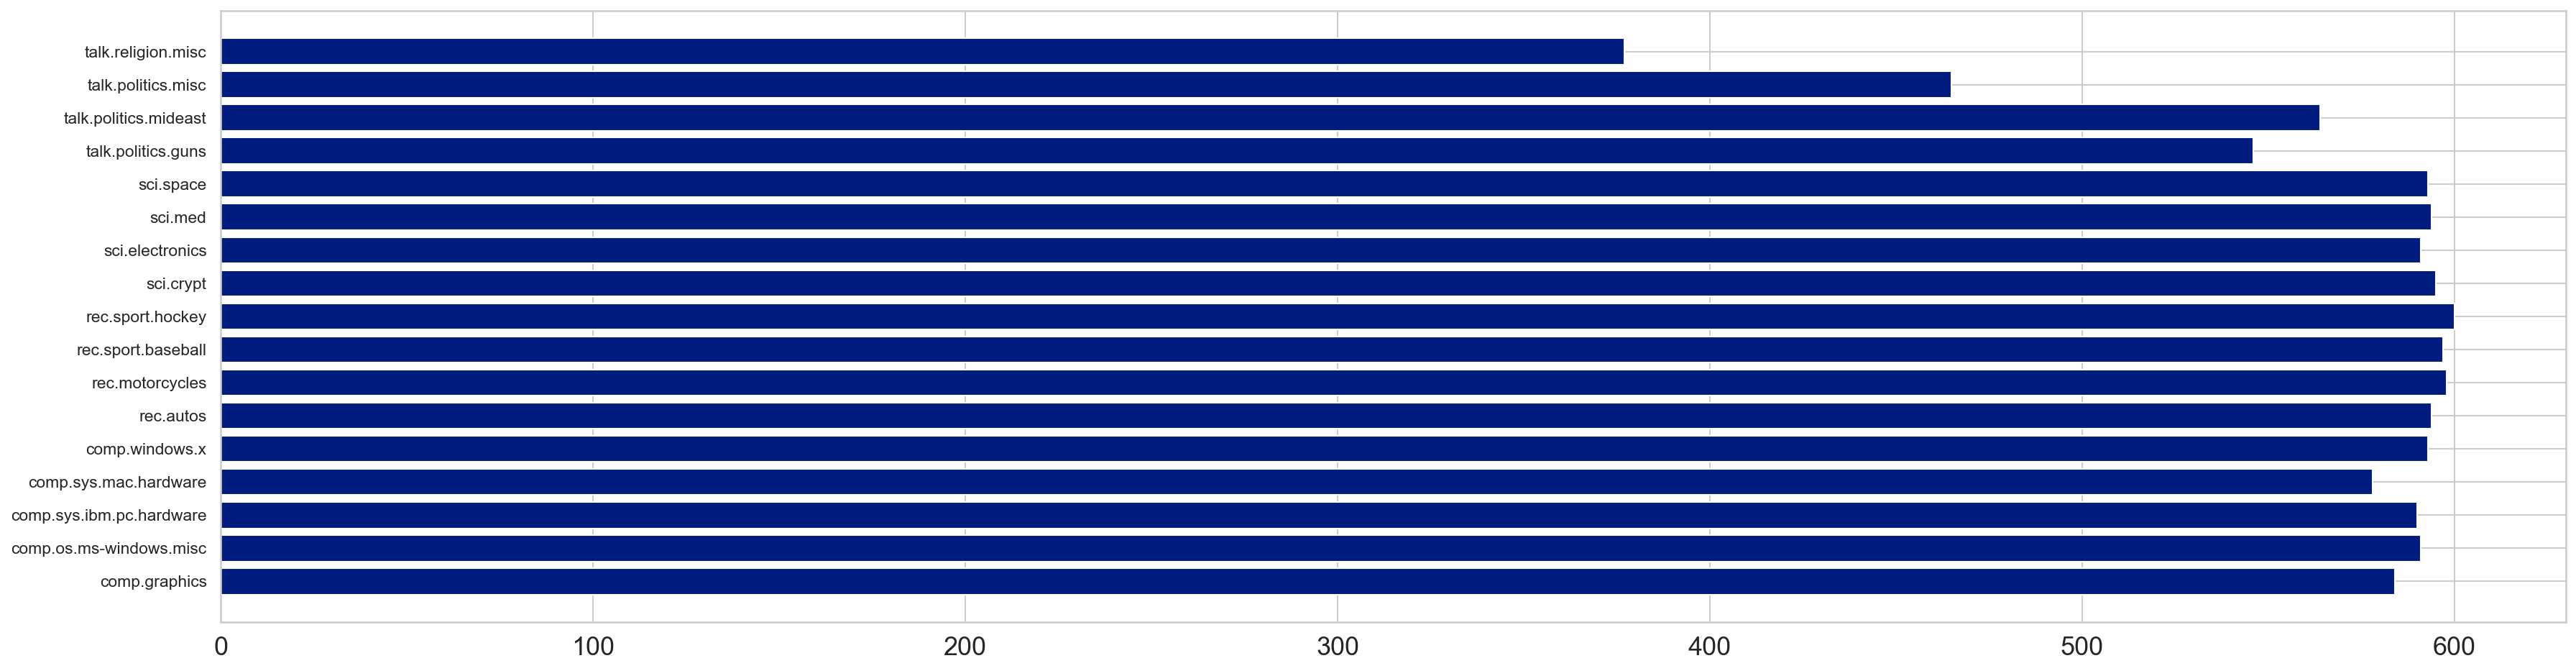

In [296]:
# plotting the count of documents per category
category = list(count_per_category.keys())
count = list(count_per_category.values())
plt.barh(range(len(count_per_category)), count, tick_label=category)
plt.show()

**Plot Analysis**

The above plot illustrates the number of documents per topic, wherein the topic named rec.sport.hockey has the highest number of documents, while the topic named talk.religion.misc has the lowest number of documents.

In [297]:
# accesing the features and target
X_train_data = pd.DataFrame(total_training_data['data'], columns=["post"])
y_train = pd.DataFrame(total_training_data['target'])
X_test_data = pd.DataFrame(total_testing_data['data'], columns=["post"])
y_test = pd.DataFrame(total_testing_data['target'])

In [298]:
# viewing the training data
X_train_data

post
0     \n\nThere were many injustices in the middle a...
1     \n\nThis actually supports Bill's speculation ...
2     \nApplied Engineering makes a NuBus card calle...
3     Mark McWiggins <markmc@halcyon.com> reminds us...
4     \nExcellently put!\n\nEven as a libertarian, I...
...                                                 ...
9645  \nAll Toyotas have airbags with a real horn. C...
9646    HELP!\nMaybe anybody know names of conferenc...
9647  \nI'm not aware that the US government conside...
9648  \n  Nut or not, he was clearly a liar.  He sai...
9649  \nIt likely has nothing to do with "chunks of ...

[9650 rows x 1 columns]

In [299]:
# viewing the testing data
y_test

0
0     10
1     12
2      4
3     13
4      2
...   ..
6420   0
6421  12
6422   2
6423  15
6424   6

[6425 rows x 1 columns]

## **Data Preprocessing**

In [300]:
def preprocess_post(post):
  """
  Function to preprocess the post which involves removing URL,
  removing special characters, numbers, extra spaces, etc
  """
  post = re.sub(r'\S*https?:\S*', '', post)
  post = re.sub('[^A-Za-z]+', ' ', post)

  altered_post_words = []
  for word in post.split():
    if word.lower() not in stopwords.words("english"):
      altered_post_words.append(word)
  
  post = ' '.join(altered_post_words)

  post = post.lower()

  post = post.strip()

  return post

In [301]:
# creating a new column that has preprocessed posts
X_train_data['preprocessed_post'] = X_train_data['post'].apply(lambda x: preprocess_post(x))

In [302]:
# viewing the newly added feature i.e. preprocessed_post from the training data
X_train_data

post  \
0     \n\nThere were many injustices in the middle a...   
1     \n\nThis actually supports Bill's speculation ...   
2     \nApplied Engineering makes a NuBus card calle...   
3     Mark McWiggins <markmc@halcyon.com> reminds us...   
4     \nExcellently put!\n\nEven as a libertarian, I...   
...                                                 ...   
9645  \nAll Toyotas have airbags with a real horn. C...   
9646    HELP!\nMaybe anybody know names of conferenc...   
9647  \nI'm not aware that the US government conside...   
9648  \n  Nut or not, he was clearly a liar.  He sai...   
9649  \nIt likely has nothing to do with "chunks of ...   

                                      preprocessed_post  
0     many injustices middle ages truely sad would h...  
1     actually supports bill speculation backdoor rs...  
2     applied engineering makes nubus card called qu...  
3     mark mcwiggins markmc halcyon com reminds us m...  
4     excellently put even libertarian admit governm...  
...                                                 ...  
9645  toyotas airbags real horn come hard put little...  
9646  help maybe anybody know names conferences plea...  
9647  aware us government considers dangerous case n...  
9648  nut clearly liar said would surrender local ra...  
9649  likely nothing chunks plaque sounds like may n...  

[9650 rows x 2 columns]

## **Vectorization**

In [303]:
# initialize the vectorizer for word importance
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95)

# applying the vectorizer to the preprocessed posts
X_train = vectorizer.fit_transform(X_train_data['preprocessed_post'])
X_test = vectorizer.transform(X_test_data['post'])

In [304]:
# viewing the sparse matrix representation of the features in the training data
X_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Classification**

In [305]:
# defining the classification models
classification_models = ['K Nearest Neighbor', 'K Nearest Neighbor Hypertuned', 'Support Vector Machine', 'Support Vector Machine Hypertuned', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes Hypertuned']

In [306]:
# initializing lists to track the training and testing accuracies
all_category_train_accuracy = []
all_category_test_accuracy = []

In [307]:
# initializing lists to track performance metrics
all_precision_score = []
all_recall_score = []
all_f1_score = []

### **K-Nearest Neighbour Classifier**


#### **Training**

In [308]:
# initializing and fitting the KNN Classifier
all_knn_clf = KNeighborsClassifier(n_neighbors=4)
all_knn_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

#### **Evaluation**

In [309]:
# calculating training accuracy
all_knn_train_prediction = all_knn_clf.predict(X_train)
all_knn_train_accuracy = accuracy_score(y_train,all_knn_train_prediction)
print("Training Accuracy:", all_knn_train_accuracy*100)
all_category_train_accuracy.append(all_knn_train_accuracy)

# calculating testing accuracy
all_knn_test_prediction = all_knn_clf.predict(X_test)
all_knn_test_accuracy = accuracy_score(y_test, all_knn_test_prediction)
print("Testing Accuracy:", all_knn_test_accuracy*100)
all_category_test_accuracy.append(all_knn_test_accuracy)

Training Accuracy: 41.554404145077726
Testing Accuracy: 8.90272373540856


In [310]:
# creating the confusion matrix
all_knn_conf_matrix = confusion_matrix(y_test, all_knn_test_prediction)

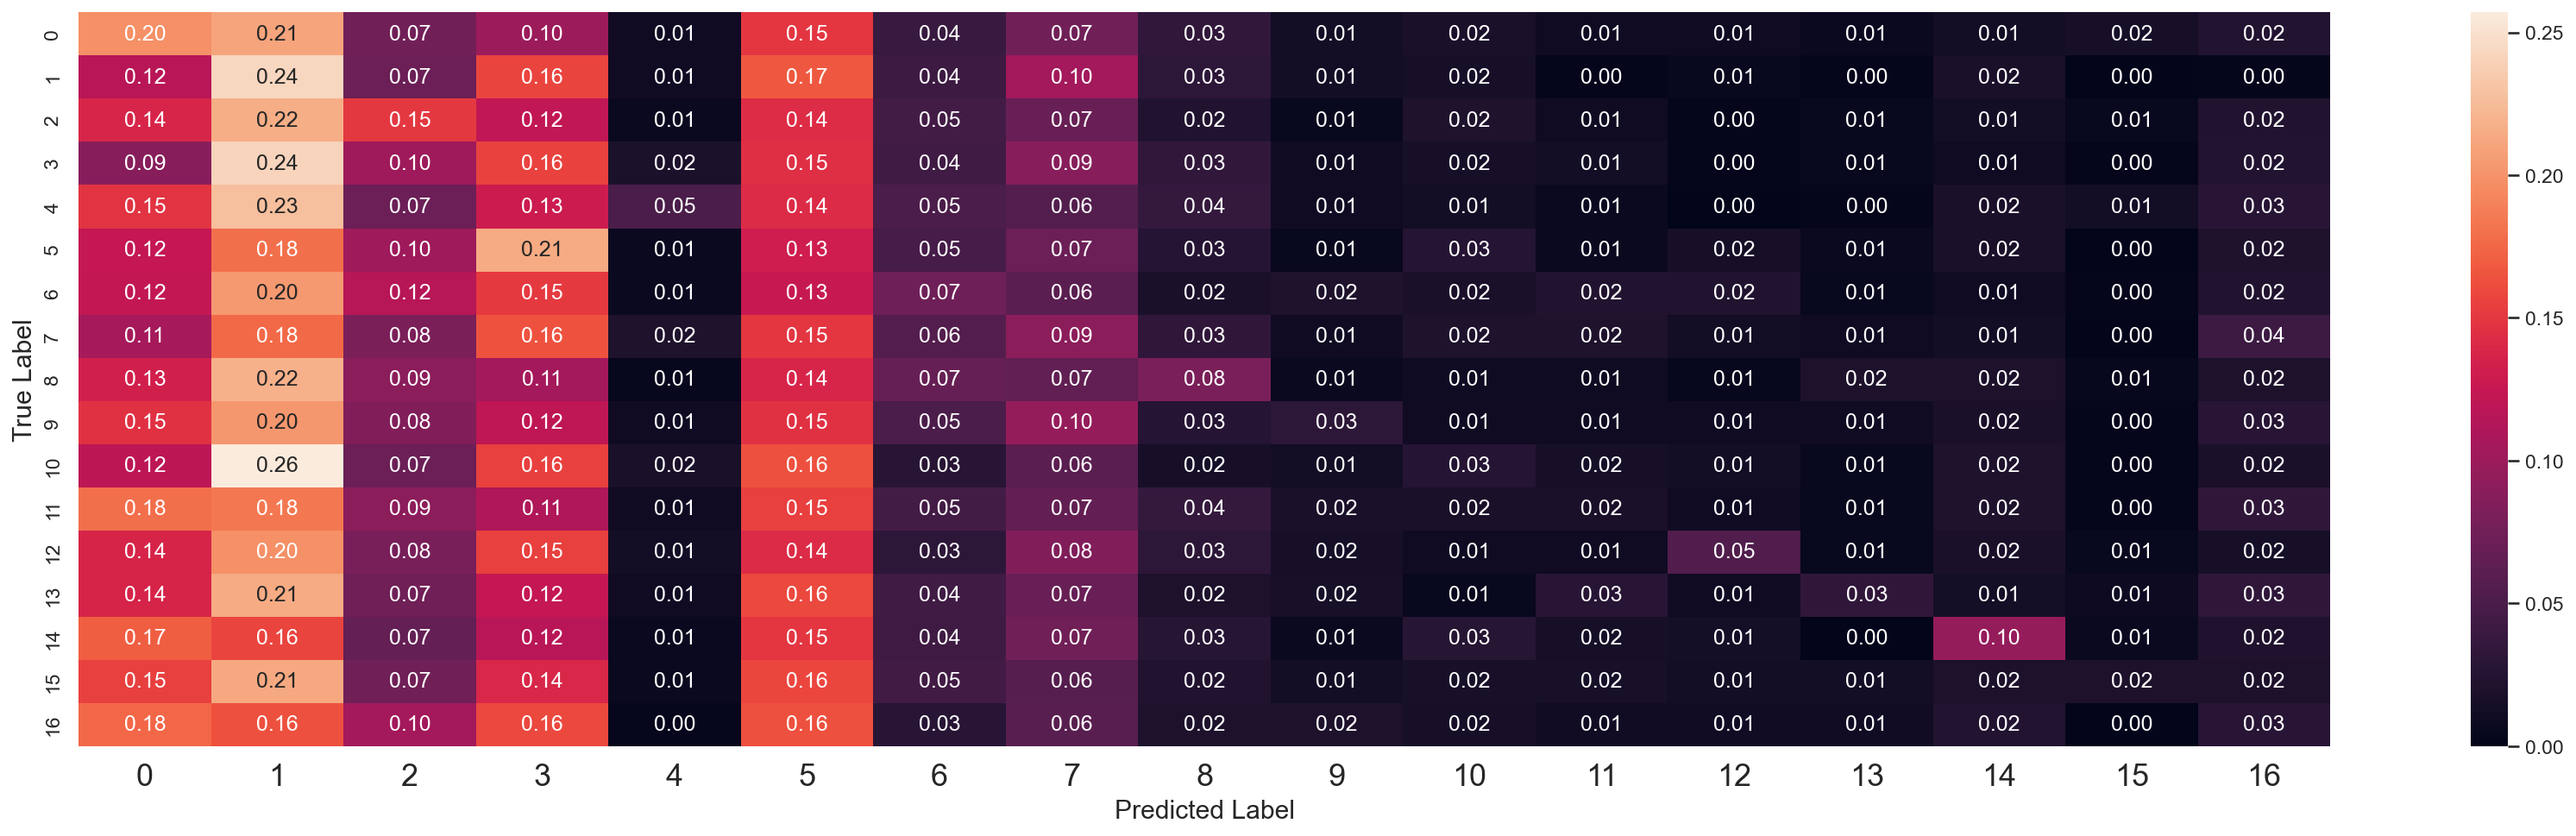

In [311]:
# normalising and viewing the confusion matrix
all_knn_conf_matrix_norm = all_knn_conf_matrix.astype('float') / all_knn_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_knn_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [312]:
# calculating metrics for the prediction
all_knn_metrics = metrics.classification_report(y_test, all_knn_test_prediction,target_names=categories)
print(all_knn_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.09      0.20      0.12       389
 comp.os.ms-windows.misc       0.07      0.24      0.11       394
comp.sys.ibm.pc.hardware       0.10      0.15      0.12       392
   comp.sys.mac.hardware       0.07      0.16      0.09       385
          comp.windows.x       0.24      0.05      0.08       395
               rec.autos       0.05      0.13      0.08       396
         rec.motorcycles       0.10      0.07      0.08       398
      rec.sport.baseball       0.08      0.09      0.08       397
        rec.sport.hockey       0.16      0.08      0.11       399
               sci.crypt       0.14      0.03      0.05       396
         sci.electronics       0.09      0.03      0.04       393
                 sci.med       0.08      0.02      0.03       396
               sci.space       0.26      0.05      0.09       394
      talk.politics.guns       0.22      0.03      0.06       364
   talk.p

#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [313]:
# initializing grid search cross validation for hyperparameter tuning
neighbour_values=[]
for i in range(1,15):
  neighbour_values.append(i)
weight_values=['uniform', 'distance']
leaf_values = [30,40,50,60]

all_knn_parameters_dict = dict(n_neighbors=neighbour_values, weights=weight_values,leaf_size=leaf_values)
all_knn_grid = GridSearchCV(all_knn_clf, all_knn_parameters_dict, cv=5, scoring='accuracy')
all_knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=4),
             param_grid={'leaf_size': [30, 40, 50, 60],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [314]:
# viewing the best parameters
print(all_knn_grid.best_params_)

{'leaf_size': 30, 'n_neighbors': 1, 'weights': 'uniform'}


##### **Retraining**

In [315]:
# reinitializing and refitting the KNN Classifier
all_knn_ht_clf = KNeighborsClassifier(n_neighbors=1,weights='uniform',leaf_size=30)
all_knn_ht_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

##### **Revaluation**

In [316]:
# recalculating training accuracy
all_knn_ht_train_prediction = all_knn_ht_clf.predict(X_train)
all_knn_ht_train_accuracy = accuracy_score(y_train,all_knn_ht_train_prediction)
print("Training Accuracy with tuned Hyperparameters:",all_knn_ht_train_accuracy*100)
all_category_train_accuracy.append(all_knn_ht_train_accuracy)

# recalculating testing accuracy
all_knn_ht_test_prediction = all_knn_ht_clf.predict(X_test)
all_knn_ht_test_accuracy = accuracy_score(y_test, all_knn_ht_test_prediction)
print("Testing Accuracy with tuned Hyperparameters:",all_knn_ht_test_accuracy*100)
all_category_test_accuracy.append(all_knn_ht_test_accuracy)

Training Accuracy with tuned Hyperparameters: 97.139896373057
Testing Accuracy with tuned Hyperparameters: 11.859922178988327


In [317]:
# creating the confusion matrix
all_knn_ht_conf_matrix = confusion_matrix(y_test, all_knn_ht_test_prediction)

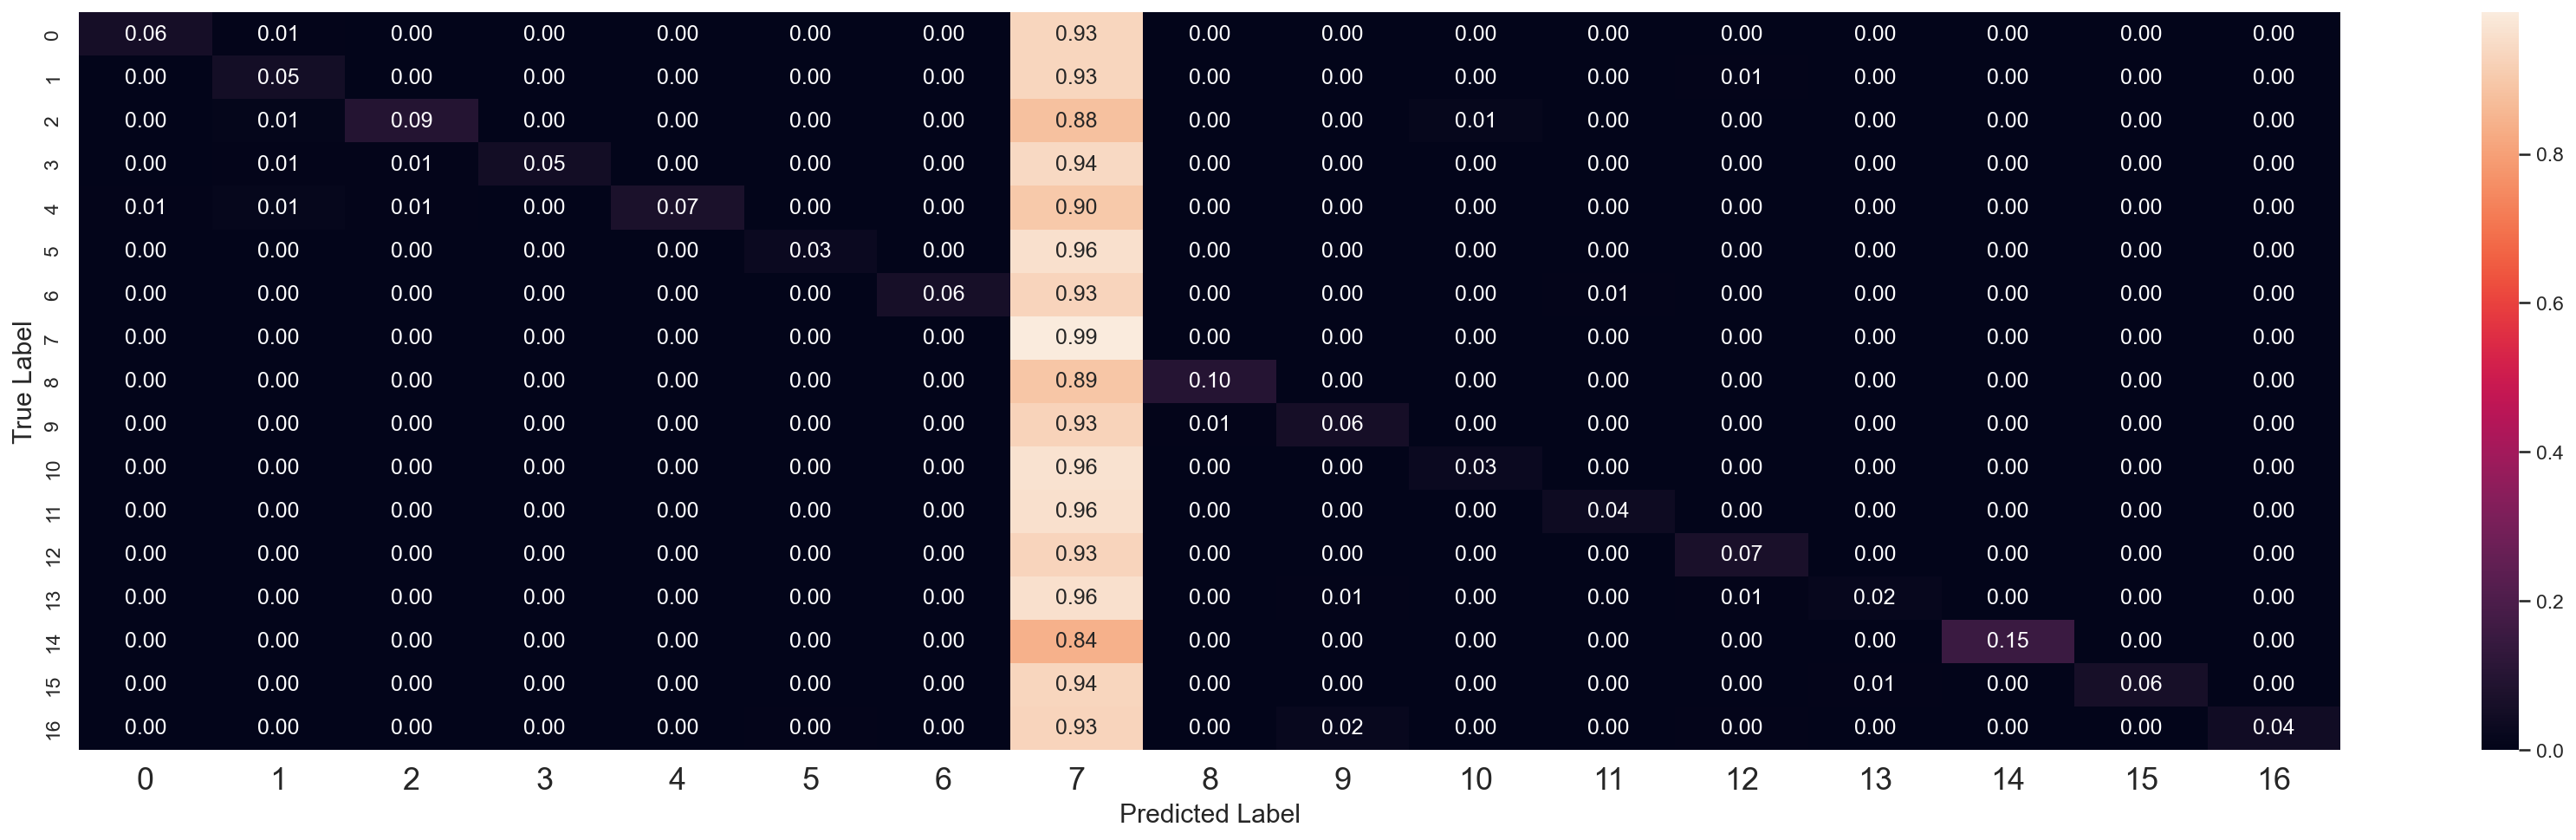

In [318]:
# renormalising and reviewing the confusion matrix
all_knn_ht_conf_matrix_norm = all_knn_ht_conf_matrix.astype('float') / all_knn_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_knn_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [319]:
# calculating metrics for the prediction
all_knn_ht_metrics = metrics.classification_report(y_test, all_knn_ht_test_prediction,target_names=categories)
print(all_knn_ht_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.85      0.06      0.11       389
 comp.os.ms-windows.misc       0.56      0.05      0.09       394
comp.sys.ibm.pc.hardware       0.84      0.09      0.17       392
   comp.sys.mac.hardware       0.95      0.05      0.09       385
          comp.windows.x       0.90      0.07      0.13       395
               rec.autos       0.79      0.03      0.05       396
         rec.motorcycles       0.80      0.06      0.11       398
      rec.sport.baseball       0.07      0.99      0.12       397
        rec.sport.hockey       0.95      0.10      0.18       399
               sci.crypt       0.71      0.06      0.10       396
         sci.electronics       0.55      0.03      0.05       393
                 sci.med       0.79      0.04      0.07       396
               sci.space       0.84      0.07      0.13       394
      talk.politics.guns       0.60      0.02      0.03       364
   talk.p

### **Support Vector Machine Classifier**

#### **Training**

In [320]:
# initializing and fitting the SVM classifier
all_svm_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, multi_class='ovr', max_iter=1000)
all_svm_clf.fit(X_train,y_train)

LinearSVC(dual=False)

#### **Evaluation**

In [321]:
# calculating training accuracy
all_svm_train_prediction = all_svm_clf.predict(X_train)
all_svm_train_accuracy = accuracy_score(y_train,all_svm_train_prediction)
print("Training Accuracy:",all_svm_train_accuracy*100)
all_category_train_accuracy.append(all_svm_train_accuracy)

# calculating testing accuracy
all_svm_test_prediction = all_svm_clf.predict(X_test)
all_svm_test_accuracy = accuracy_score(y_test, all_svm_test_prediction)
print("Testing Accuracy:",all_svm_test_accuracy*100)
all_category_test_accuracy.append(all_svm_test_accuracy)

Training Accuracy: 96.9119170984456
Testing Accuracy: 69.58754863813229


In [322]:
# creating the confusion matrix
all_svm_conf_matrix = confusion_matrix(y_test, all_svm_test_prediction)

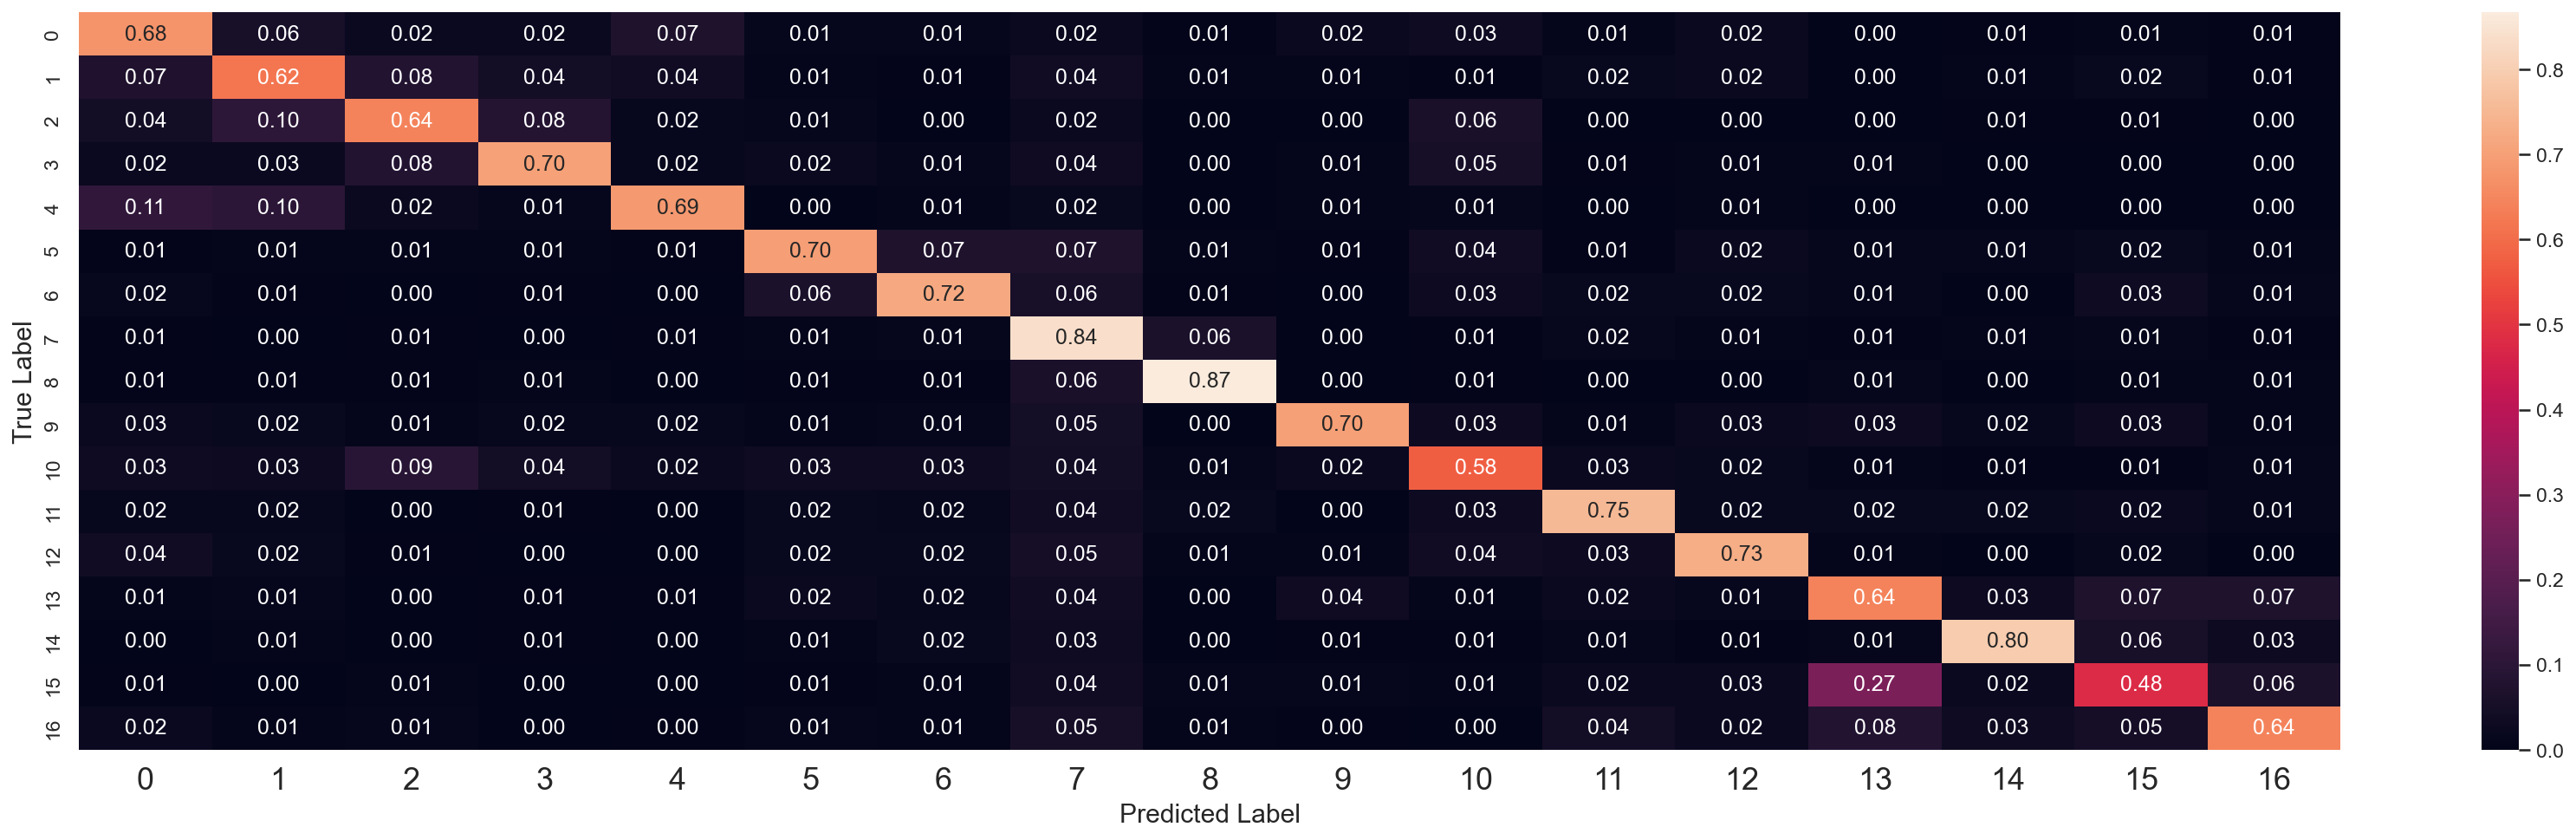

In [323]:
# normalizing and viewing the confusion matrix
all_svm_conf_matrix_norm = all_svm_conf_matrix.astype('float') / all_svm_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_svm_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [324]:
# calculating metrics for the prediction
all_svm_metrics = metrics.classification_report(y_test, all_svm_test_prediction,target_names=categories)
print(all_svm_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.61      0.68      0.64       389
 comp.os.ms-windows.misc       0.60      0.62      0.61       394
comp.sys.ibm.pc.hardware       0.65      0.64      0.64       392
   comp.sys.mac.hardware       0.72      0.70      0.71       385
          comp.windows.x       0.77      0.69      0.73       395
               rec.autos       0.74      0.70      0.72       396
         rec.motorcycles       0.75      0.72      0.73       398
      rec.sport.baseball       0.57      0.84      0.68       397
        rec.sport.hockey       0.85      0.87      0.86       399
               sci.crypt       0.83      0.70      0.76       396
         sci.electronics       0.62      0.58      0.60       393
                 sci.med       0.78      0.75      0.76       396
               sci.space       0.76      0.73      0.74       394
      talk.politics.guns       0.59      0.64      0.62       364
   talk.p

#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [325]:
# intializing grid search cross validation for hyperparameter tuning
penalty_values=['l1','l2']
tolerance_values = [0.1,0.001]
C_values=[2,5,10]
all_svm_parameters_dict = dict(penalty=penalty_values, C=C_values, tol=tolerance_values)
all_svm_grid = GridSearchCV(all_svm_clf, all_svm_parameters_dict, cv=5, scoring='accuracy')
all_svm_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [2, 5, 10], 'penalty': ['l1', 'l2'],
                         'tol': [0.1, 0.001]},
             scoring='accuracy')

In [326]:
# viewing the best parameters
print(all_svm_grid.best_params_)

{'C': 2, 'penalty': 'l2', 'tol': 0.1}


##### **Retraining**

In [327]:
# reinitializing and refitting the SVM classifier
all_svm_ht_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, multi_class='ovr', max_iter=1000, C=2, tol=0.1)
all_svm_ht_clf.fit(X_train,y_train)

LinearSVC(C=2, dual=False, tol=0.1)

##### **Revaluation**

In [328]:
# recalculating training accuracy
all_svm_ht_train_prediction = all_svm_ht_clf.predict(X_train)
all_svm_ht_train_accuracy = accuracy_score(y_train,all_svm_ht_train_prediction)
print("Training Accuracy with tuned hyperparameters:",all_svm_ht_train_accuracy*100)
all_category_train_accuracy.append(all_svm_ht_train_accuracy)

# recalculating testing accuracy
all_svm_ht_test_prediction = all_svm_ht_clf.predict(X_test)
all_svm_ht_test_accuracy = accuracy_score(y_test, all_svm_ht_test_prediction)
print("Testing Accuracy with tuned hyperparameters:",all_svm_ht_test_accuracy*100)
all_category_test_accuracy.append(all_svm_ht_test_accuracy)

Training Accuracy with tuned hyperparameters: 96.05181347150258
Testing Accuracy with tuned hyperparameters: 69.83657587548639


In [329]:
# creating the confusion matrix
all_svm_ht_conf_matrix = confusion_matrix(y_test, all_svm_ht_test_prediction)

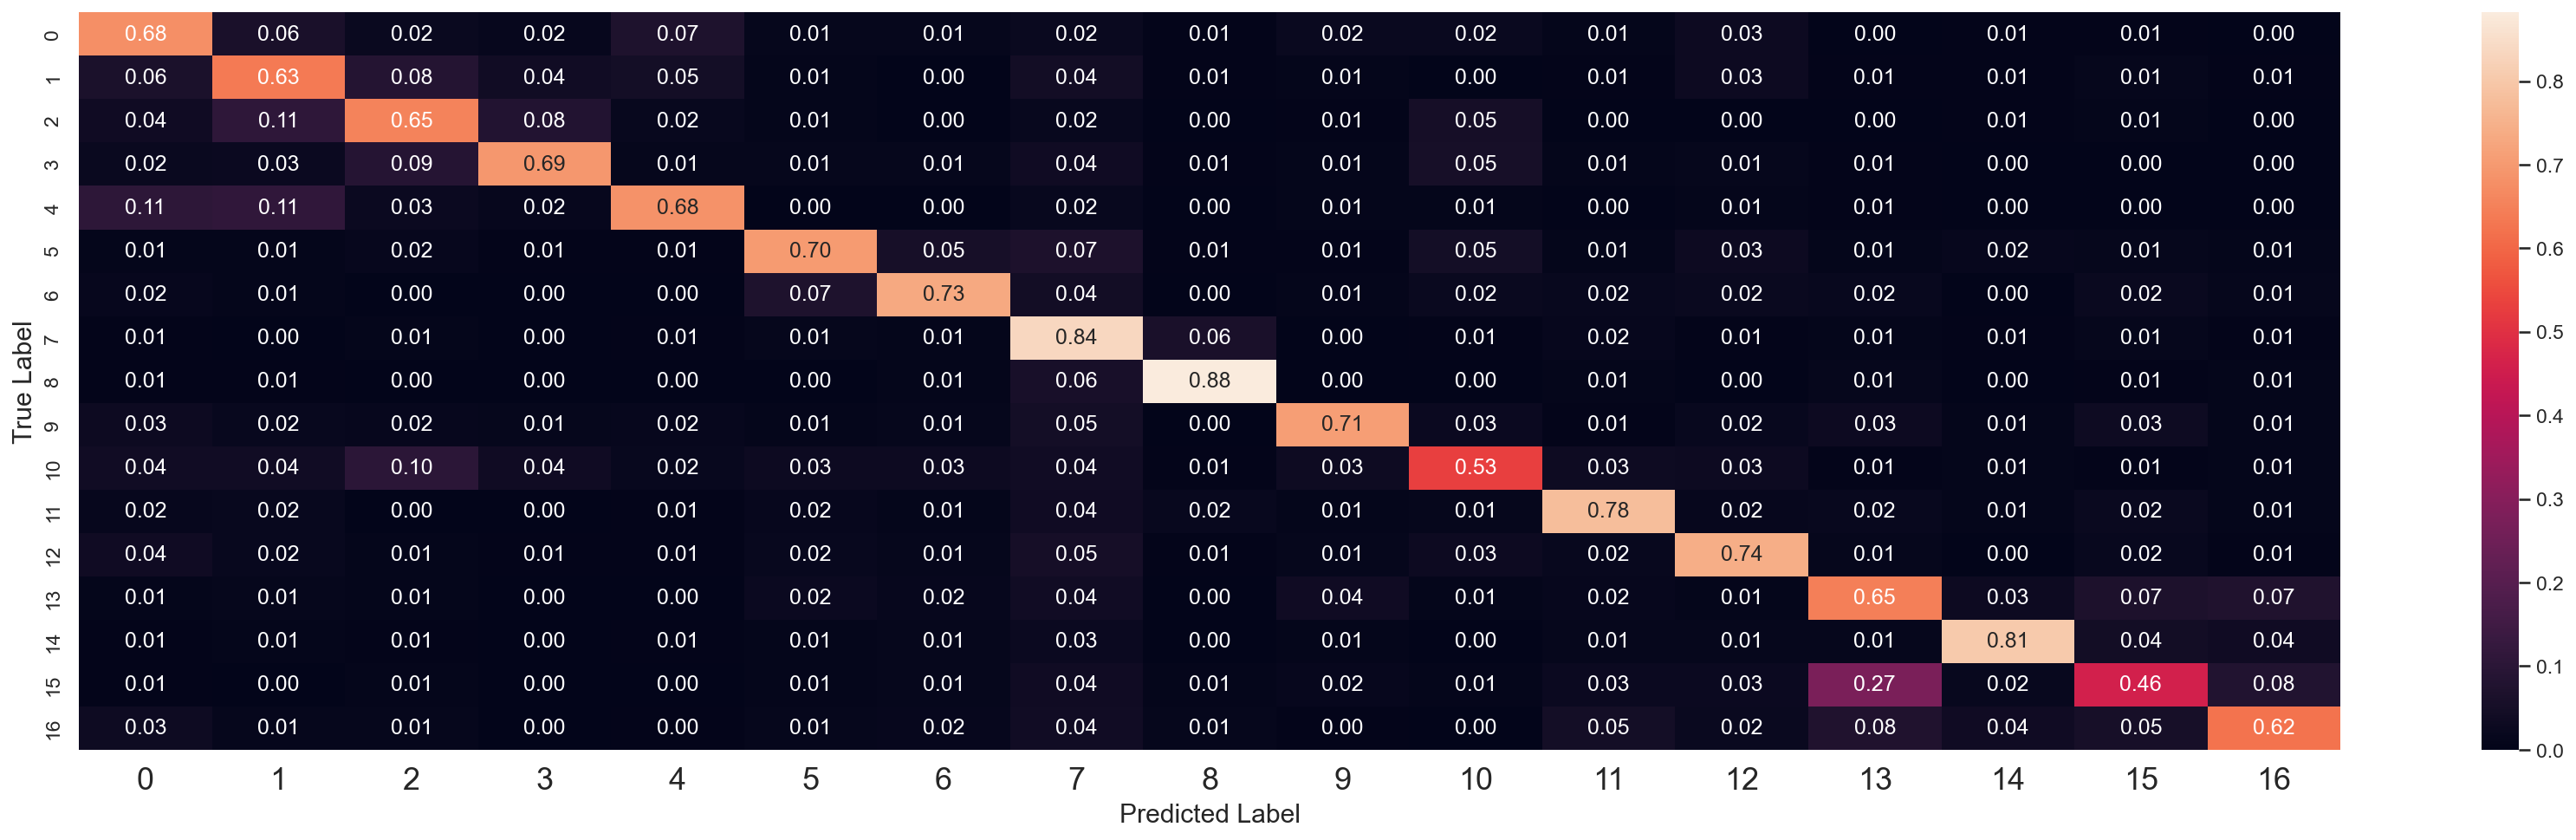

In [330]:
# renormalizing and reviewing the confusion matrix
all_svm_ht_conf_matrix_norm = all_svm_ht_conf_matrix.astype('float') / all_svm_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_svm_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [331]:
# calculating metrics for the prediction
all_svm_ht_metrics = metrics.classification_report(y_test, all_svm_ht_test_prediction, target_names=categories)
print(all_svm_ht_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.61      0.68      0.64       389
 comp.os.ms-windows.misc       0.58      0.63      0.61       394
comp.sys.ibm.pc.hardware       0.62      0.65      0.64       392
   comp.sys.mac.hardware       0.76      0.69      0.72       385
          comp.windows.x       0.76      0.68      0.72       395
               rec.autos       0.74      0.70      0.72       396
         rec.motorcycles       0.78      0.73      0.75       398
      rec.sport.baseball       0.59      0.84      0.69       397
        rec.sport.hockey       0.87      0.88      0.88       399
               sci.crypt       0.80      0.71      0.75       396
         sci.electronics       0.64      0.53      0.58       393
                 sci.med       0.79      0.78      0.78       396
               sci.space       0.74      0.74      0.74       394
      talk.politics.guns       0.59      0.65      0.62       364
   talk.p

### **Multinomial Naive Bayes Classifier**

#### **Training**

In [332]:
# initializing and fitting the Multinomial Naive Bayes Classifier
all_mnb_clf = MultinomialNB(alpha=0.1)
all_mnb_clf.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

#### **Evaluation**

In [333]:
# calculating training accuracy
all_mnb_train_prediction = all_mnb_clf.predict(X_train)
all_mnb_train_accuracy = accuracy_score(y_train, all_mnb_train_prediction)
print("Training Accuracy:",all_mnb_train_accuracy*100)
all_category_train_accuracy.append(all_mnb_train_accuracy)

# calculating the testing accuracy 
all_mnb_test_prediction = all_mnb_clf.predict(X_test)
all_mnb_test_accuracy= accuracy_score(y_test, all_mnb_test_prediction)
print("Testing Accuracy:",all_mnb_test_accuracy*100)
all_category_test_accuracy.append(all_mnb_test_accuracy)

Training Accuracy: 93.17098445595855
Testing Accuracy: 71.37743190661479


In [334]:
# creating the confusion matrix
all_mnb_conf_matrix = confusion_matrix(y_test, all_mnb_test_prediction)

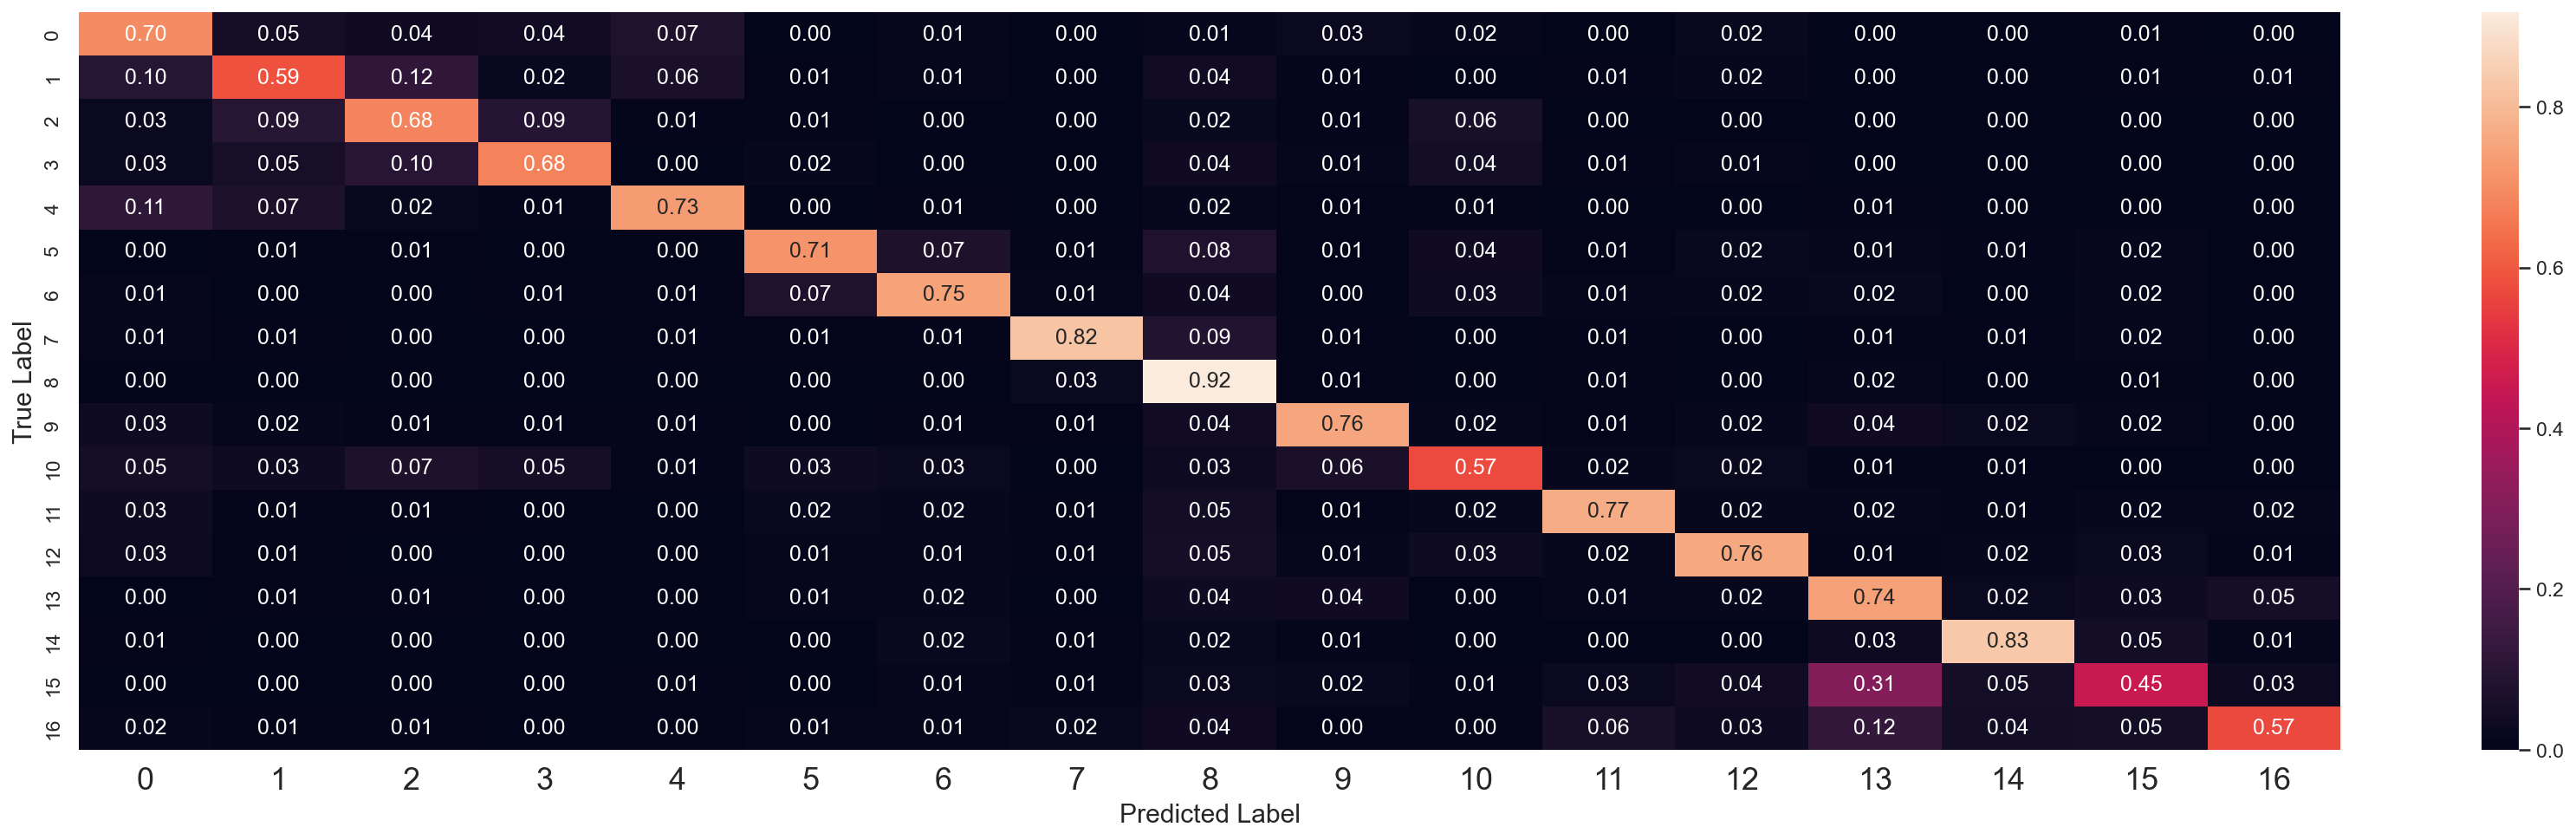

In [335]:
# normalising and viewing the confusion matrix
all_mnb_conf_matrix_norm = all_mnb_conf_matrix.astype('float') / all_mnb_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_mnb_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [336]:
# calculating metrics for the prediction
all_mnb_metrics = metrics.classification_report(y_test, all_mnb_test_prediction,target_names=categories)
print(all_mnb_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.60      0.70      0.64       389
 comp.os.ms-windows.misc       0.62      0.59      0.60       394
comp.sys.ibm.pc.hardware       0.64      0.68      0.66       392
   comp.sys.mac.hardware       0.74      0.68      0.71       385
          comp.windows.x       0.79      0.73      0.76       395
               rec.autos       0.79      0.71      0.75       396
         rec.motorcycles       0.77      0.75      0.76       398
      rec.sport.baseball       0.89      0.82      0.85       397
        rec.sport.hockey       0.61      0.92      0.73       399
               sci.crypt       0.78      0.76      0.77       396
         sci.electronics       0.66      0.57      0.61       393
                 sci.med       0.82      0.77      0.79       396
               sci.space       0.78      0.76      0.77       394
      talk.politics.guns       0.58      0.74      0.65       364
   talk.p

#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [337]:
# initializing Grid Search Cross Validation for hyperparameter tuning
alpha_range = [0.0001, 0.001, 0.01, 0.2, 0.5, 0.7, 1, 2, 5, 8, 9, 10]
fit_vals=[True,False]
all_mnb_parameters_dict = dict(alpha=alpha_range,fit_prior=fit_vals)
all_mnb_grid = GridSearchCV(all_mnb_clf, all_mnb_parameters_dict, cv=5, scoring='accuracy')
all_mnb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(alpha=0.1),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.2, 0.5, 0.7, 1, 2, 5,
                                   8, 9, 10],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [338]:
# viewing the best parameters
all_mnb_grid.best_params_

{'alpha': 0.2, 'fit_prior': False}

##### **Retraining**

In [339]:
# reinitializing and refitting the Multinomial Naive Bayes Classifier
all_mnb_ht_clf = MultinomialNB(alpha=0.2,fit_prior=False)
all_mnb_ht_clf.fit(X_train,y_train)

MultinomialNB(alpha=0.2, fit_prior=False)

##### **Revaluation**

In [340]:
# recalculating training accuracy
all_mnb_ht_train_prediction = all_mnb_ht_clf.predict(X_train)
all_mnb_ht_train_accuracy = accuracy_score(y_train, all_mnb_ht_train_prediction)
print("Training Accuracy with tuned hyperparameters:",all_mnb_ht_train_accuracy*100)
all_category_train_accuracy.append(all_mnb_ht_train_accuracy)

# recalculating testing accuracy
all_mnb_ht_test_prediction = all_mnb_ht_clf.predict(X_test)
all_mnb_ht_test_accuracy= accuracy_score(y_test, all_mnb_ht_test_prediction)
print("Testing Accuracy with tuned hyperparameters:",all_mnb_ht_test_accuracy*100)
all_category_test_accuracy.append(all_mnb_ht_test_accuracy)

Training Accuracy with tuned hyperparameters: 92.42487046632124
Testing Accuracy with tuned hyperparameters: 71.62645914396887


In [341]:
# creating the confusion matrix
all_mnb_ht_conf_matrix = confusion_matrix(y_test, all_mnb_ht_test_prediction)

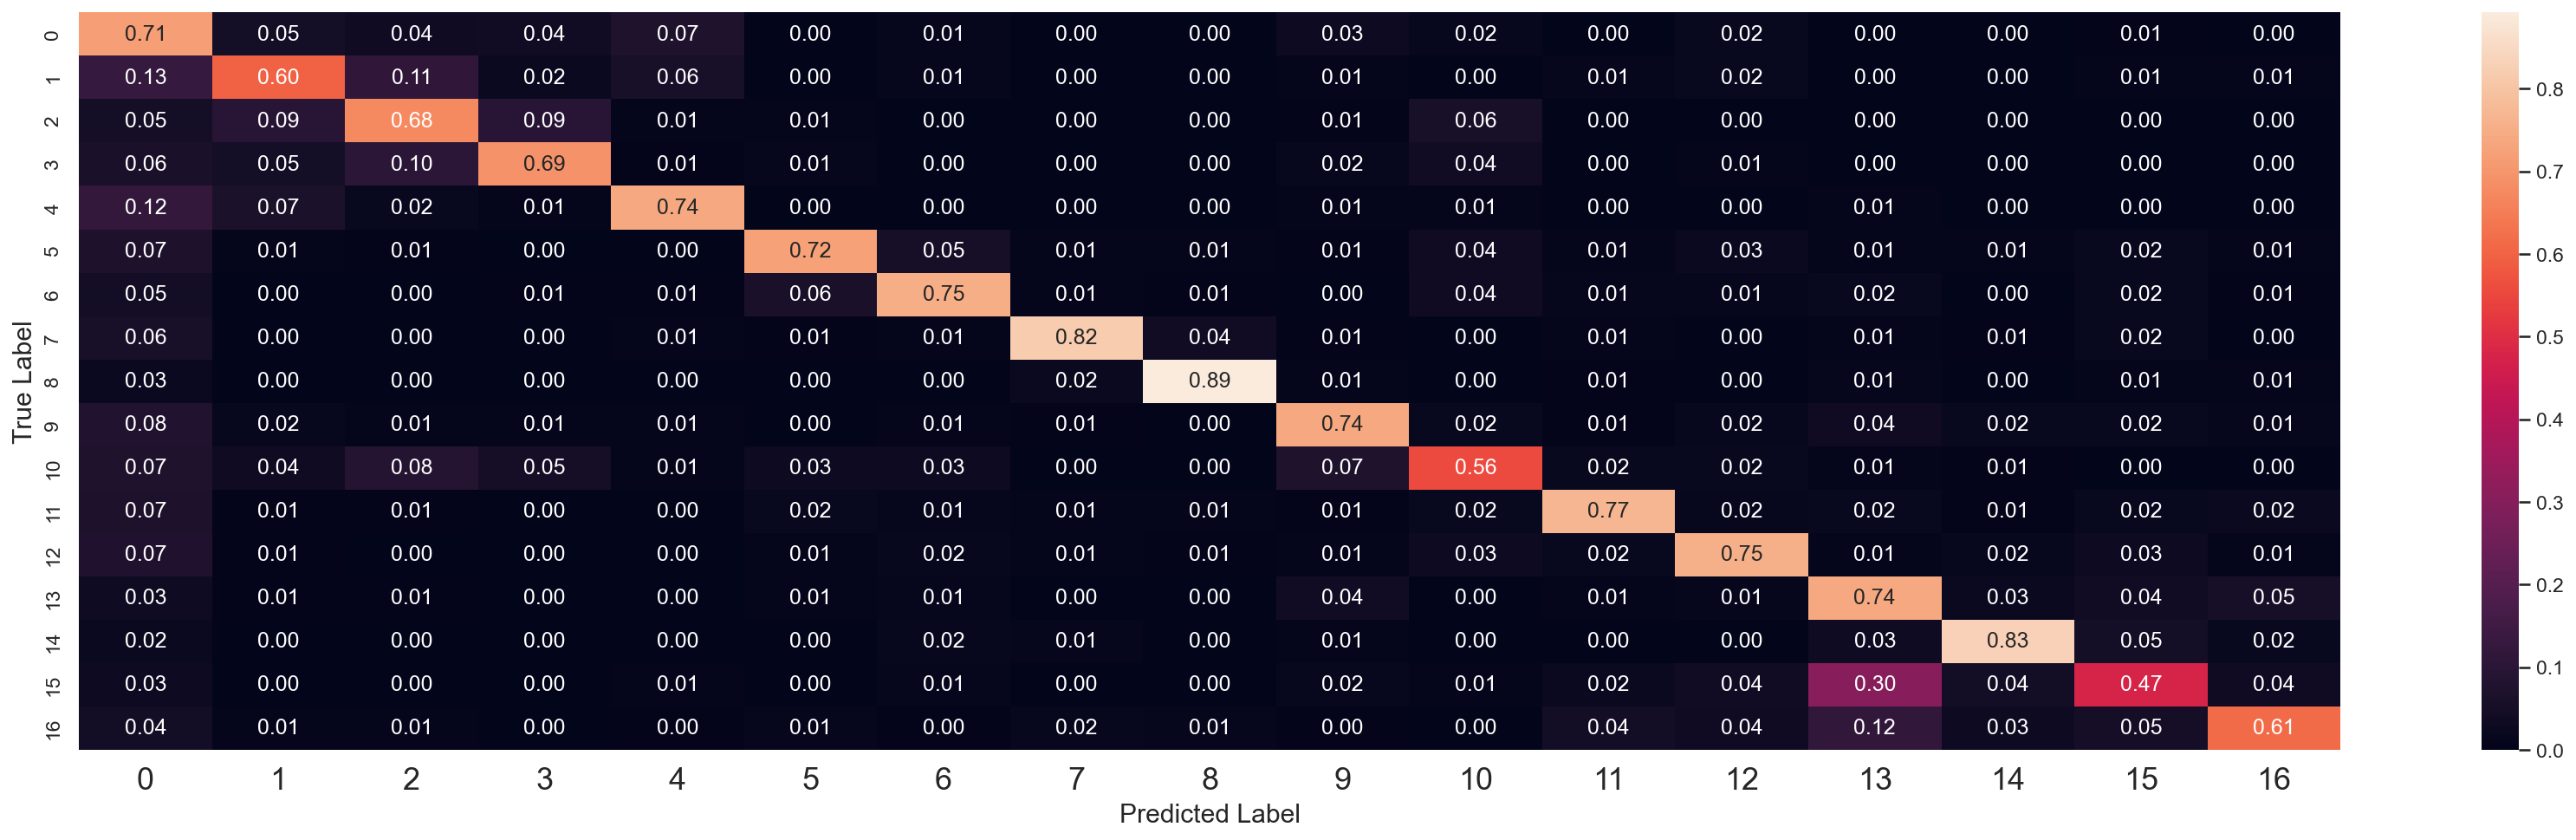

In [342]:
# renormalising and viewing the confusion matrix
all_mnb_ht_conf_matrix_norm = all_mnb_ht_conf_matrix.astype('float') / all_mnb_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(all_mnb_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [343]:
# recalculating metrics for the prediction
all_mnb_ht_metrics = metrics.classification_report(y_test, all_mnb_ht_test_prediction,target_names=categories)
print(all_mnb_ht_metrics)

                          precision    recall  f1-score   support

           comp.graphics       0.43      0.71      0.53       389
 comp.os.ms-windows.misc       0.64      0.60      0.62       394
comp.sys.ibm.pc.hardware       0.63      0.68      0.65       392
   comp.sys.mac.hardware       0.74      0.69      0.72       385
          comp.windows.x       0.79      0.74      0.77       395
               rec.autos       0.81      0.72      0.77       396
         rec.motorcycles       0.79      0.75      0.77       398
      rec.sport.baseball       0.90      0.82      0.86       397
        rec.sport.hockey       0.91      0.89      0.90       399
               sci.crypt       0.76      0.74      0.75       396
         sci.electronics       0.66      0.56      0.61       393
                 sci.med       0.83      0.77      0.80       396
               sci.space       0.78      0.75      0.77       394
      talk.politics.guns       0.59      0.74      0.65       364
   talk.p

## **Comparing Accuracies**

In [344]:
# comparing training and testing accuracies
all_model_acc_compare = pd.DataFrame({'Algorithm' : classification_models, 'Training_Accuracy' : all_category_train_accuracy, 'Testing_Accuracy' : all_category_test_accuracy})
# all_model_acc_compare.sort_values(by='Testing_Accuracy', ascending=False).style.hide_index()

all_model_acc_compare.sort_values(by='Testing_Accuracy', ascending=False).style.hide(axis="index")

From the table above, following are the observations:

1. The testing set accuracy of all the models increases after tuning the hyper-parameters.
2. With a testing set accuracy of 71.62%, the hyper-tuned MNB outperforms all the other models and is the most reliable classifier for this dataset. It is able to classify the documents better than other classifiers.
3. The accuracies of SVM and its hyper-tuned version closely follow up. 
4. The training set accuracy of the hyper-tuned KNN is the best but it doesn’t perform well on the testing set. The performance of the vanilla KNN is not at all impressive as it achieves an accuracy of just 9.05% on the testing set.
5. The training set accuracy of all the models is greater than the testing set accuracy. This means that the models are overfitting as they have learned the noise of the training documents very well.

[Text(0, 0, 'K Nearest Neighbor'),
 Text(1, 0, 'K Nearest Neighbor Hypertuned'),
 Text(2, 0, 'Support Vector Machine'),
 Text(3, 0, 'Support Vector Machine Hypertuned'),
 Text(4, 0, 'Multinomial Naive Bayes'),
 Text(5, 0, 'Multinomial Naive Bayes Hypertuned')]

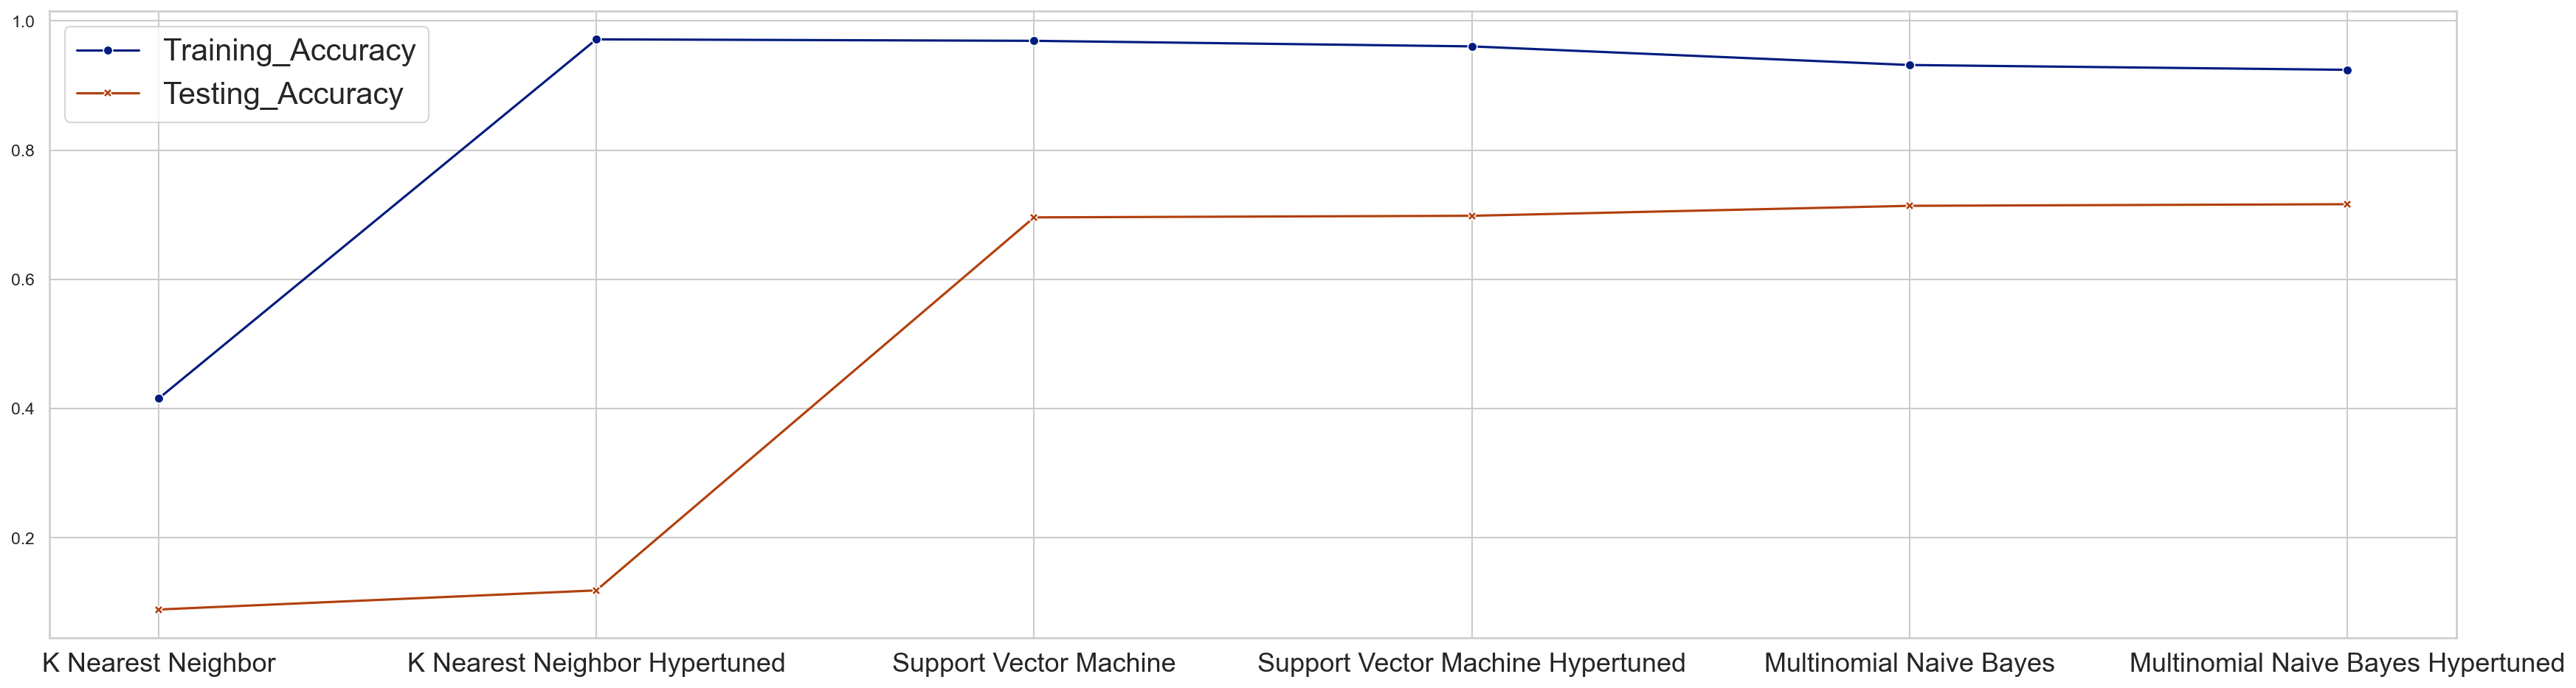

In [345]:
# visualizing the training and testing accuracies
ax = sns.lineplot(data=[all_model_acc_compare['Training_Accuracy'], all_model_acc_compare['Testing_Accuracy']], dashes=False, markers=True)
ax.set_xticks(range(len(all_model_acc_compare['Algorithm'])))
ax.set_xticklabels(all_model_acc_compare['Algorithm'])

**Plot Analysis**

The line plot illustrates the training set and testing set accuracy curves for all the models including their hyper-tuned versions. The gap between both the curves indicates huge overfitting. The KNN classifier overfits most to the training documents, whereas the MNB classifier overfits the least. The SVM classifier overfits slightly more than the MNB classifier.

## **Comparing Metrics**

In [346]:
# calculating all the performance metrics
all_precision_score.extend([metrics.precision_score(y_test, all_knn_test_prediction,average="weighted")*100,
                            metrics.precision_score(y_test, all_knn_ht_test_prediction,average="weighted")*100,
                            metrics.precision_score(y_test, all_svm_test_prediction,average="weighted")*100,
                            metrics.precision_score(y_test, all_svm_ht_test_prediction,average="weighted")*100,
                            metrics.precision_score(y_test, all_mnb_test_prediction,average="weighted")*100,
                            metrics.precision_score(y_test, all_mnb_ht_test_prediction,average="weighted")*100])

all_recall_score.extend([metrics.recall_score(y_test, all_knn_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, all_knn_ht_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, all_svm_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, all_svm_ht_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, all_mnb_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, all_mnb_ht_test_prediction,average="weighted")*100])

all_f1_score.extend([metrics.f1_score(y_test, all_knn_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, all_knn_ht_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, all_svm_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, all_svm_ht_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, all_mnb_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, all_mnb_ht_test_prediction,average="weighted")*100])

In [347]:
# displaying all the performance metrics
all_comp_metric = pd.DataFrame({'Model' : ['K Nearest Neighbor', 'K Nearest Neighbor Hypertuned', 'Support Vector Machine', 'Support Vector Machine Hypertuned', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes Hypertuned'],
                       'Precision' : all_precision_score,
                       'Recall' : all_recall_score,
                       'F1' : all_f1_score,
                       'Test_Accuracy' : all_category_test_accuracy},
                       index=["", "", "","","","17 Indivudial Groups"])

all_comp_metric.sort_values(by='Test_Accuracy', ascending=False, inplace=True)
all_comp_metric

Model  Precision  \
17 Indivudial Groups  Multinomial Naive Bayes Hypertuned  73.158085   
                                 Multinomial Naive Bayes  72.087955   
                       Support Vector Machine Hypertuned  70.363198   
                                  Support Vector Machine  70.204894   
                           K Nearest Neighbor Hypertuned  75.020130   
                                      K Nearest Neighbor  13.280690   

                         Recall         F1  Test_Accuracy  
17 Indivudial Groups  71.626459  72.004476       0.716265  
                      71.377432  71.299498       0.713774  
                      69.836576  69.839174       0.698366  
                      69.587549  69.651118       0.695875  
                      11.859922  11.300345       0.118599  
                       8.902724   8.134566       0.089027

The above table shows metrics for the 17 Individual groups. The detail comparison can be found in the **'Comparing Final Metrics'** section.

# **Operating on 4 Clubbed Newsgroups**

**Grouping the topics with similar source. For instance**:
1. Topics related to hockey, baseball, motorcycle, and autos are grouped under the term 'rec', which means recreation.
2. Topics related to graphics, ms-windows.misc, ibm.pc.hardware, mac.hardware, and windows.x are grouped under the term 'comp', which means computer.
3. Topics related to crypt, electronics, med, and space are grouped under the term 'sci', which means science.
4. Topics related to guns, mideast, politics.misc, and religion.misc are grouped under the term 'talk', which means talk.

## **Data Preparation**

In [348]:
# newly grouped categories
grouped_categories = [
                  'computer',
                  'recreation',
                  'science',
                  'talk'
                  ]

In [349]:
# setting column names for both training and testing targets
y_train.columns = ['label']
y_test.columns = ['label']

In [350]:
# transformation map for grouping the 17 indiviudal groups to 4 clubbed groups
transformation_map = {
                      0 : 0,
                      1 : 0,
                      2 : 0,
                      3 : 0,
                      4 : 0,
                      5 : 1,
                      6 : 1,
                      7 : 1,
                      8 : 1,
                      9 : 2,
                      10 : 2,
                      11 : 2,
                      12 : 2,
                      13 : 3,
                      14 : 3,
                      15 : 3,
                      16 : 3,
                    }

In [351]:
# creating a new column that has the mapped data
y_train['new_label'] = y_train['label'].map(transformation_map)
y_test['new_label'] = y_test['label'].map(transformation_map)

In [352]:
# dropping the column with original label
# y_train = y_train.drop('label', 1)
# y_test = y_test.drop('label', 1)

y_train = y_train.drop('label', axis=1)
y_test = y_test.drop('label', axis=1)

In [353]:
def count_per_new_categories(df):
  """
  Function to return the number of documents per class for new categories
  """
  dictionary={}
  cate=total_training_data.target_names
  target, targetNames, new_cat, countlist=[], [], [], []
  compCount, sciCount, talkCount, recCount=0 ,0, 0, 0
  for i in df['target']:
    new_cat.append(cate[i])
  df['category']=new_cat
  for i in df['category']:
    if('comp' in i):
      target.append(0)
      compCount+=1
      targetNames.append('computer')
    elif('rec' in i):
      target.append(1)
      targetNames.append('recreational')
      recCount+=1
    elif('sci' in i):
      target.append(2)
      targetNames.append('science')
      sciCount+=1
    elif('talk' in i):
      target.append(3)
      targetNames.append('talk')
      talkCount+=1
    else:
      target.append(4)
      targetNames.append('else')
  countlist.extend([compCount,recCount,sciCount,talkCount])
  df['new_target']=target
  df['new_target_names']=targetNames
  df = df[df.new_target != 4]
  for i in range(4):
    dictionary[grouped_categories[i]]=countlist[i]
  return dictionary

In [354]:
# intitalizng the training dataframe that has both feature and the target variable
df_entire = pd.DataFrame(total_training_data['data'], columns=["post"])
df_entire['target']=total_training_data['target']

In [355]:
# viewing the count of documents per new category
new_count_per_category = count_per_new_categories(df_entire)
new_count_per_category

{'computer': 2936, 'recreation': 2389, 'science': 2373, 'talk': 1952}

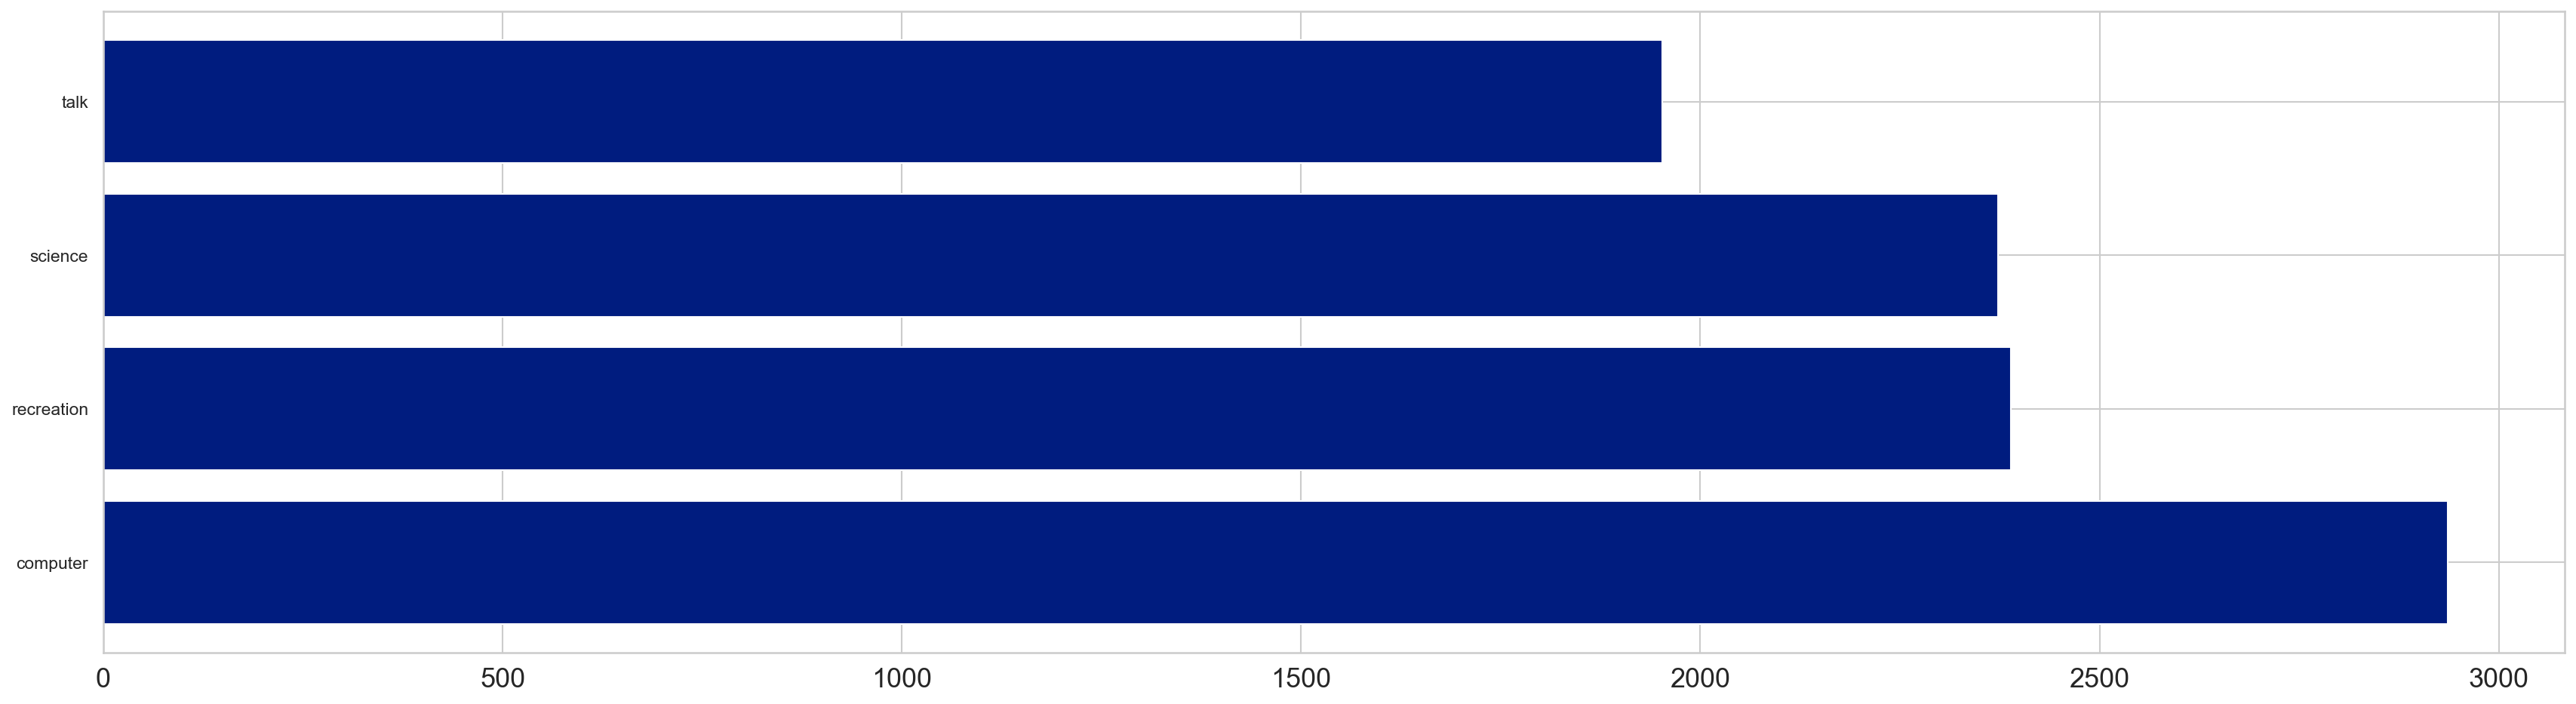

In [356]:
# plotting the count of documents per new category
category = list(new_count_per_category.keys())
count = list(new_count_per_category.values())
plt.barh(range(len(new_count_per_category)), count, tick_label=grouped_categories)
plt.show()

**Plot Analysis**

The above plot illustrates the number of documents per new topic, wherein the topic named computer has the highest number of documents, while the topic named talk has the lowest number of documents.

## **Classification**

In [357]:
# initializing lists to track the training and testing accuracies
sub_category_train_accuracy = []
sub_category_test_accuracy = []

In [358]:
# initializing lists to track performance metrics
sub_precision_score = []
sub_recall_score = []
sub_f1_score = []

### **K-Nearest Neighbour Classifier**


#### **Training**

In [359]:
# initializing and fitting the KNN Classifier
sub_knn_clf = KNeighborsClassifier(n_neighbors=4)
sub_knn_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

#### **Evaluation**

In [360]:
# calculating training accuracy
sub_knn_train_prediction = sub_knn_clf.predict(X_train)
sub_knn_train_accuracy = accuracy_score(y_train,sub_knn_train_prediction)
print("Training Accuracy:", sub_knn_train_accuracy*100)
sub_category_train_accuracy.append(sub_knn_train_accuracy)

# calculating testing accuracy
sub_knn_test_prediction = sub_knn_clf.predict(X_test)
sub_knn_test_accuracy = accuracy_score(y_test, sub_knn_test_prediction)
print("Testing Accuracy:", sub_knn_test_accuracy*100)
sub_category_test_accuracy.append(sub_knn_test_accuracy)

Training Accuracy: 59.39896373056995
Testing Accuracy: 28.715953307392994


In [361]:
# creating the confusion matrix
sub_knn_conf_matrix = confusion_matrix(y_test, sub_knn_test_prediction)

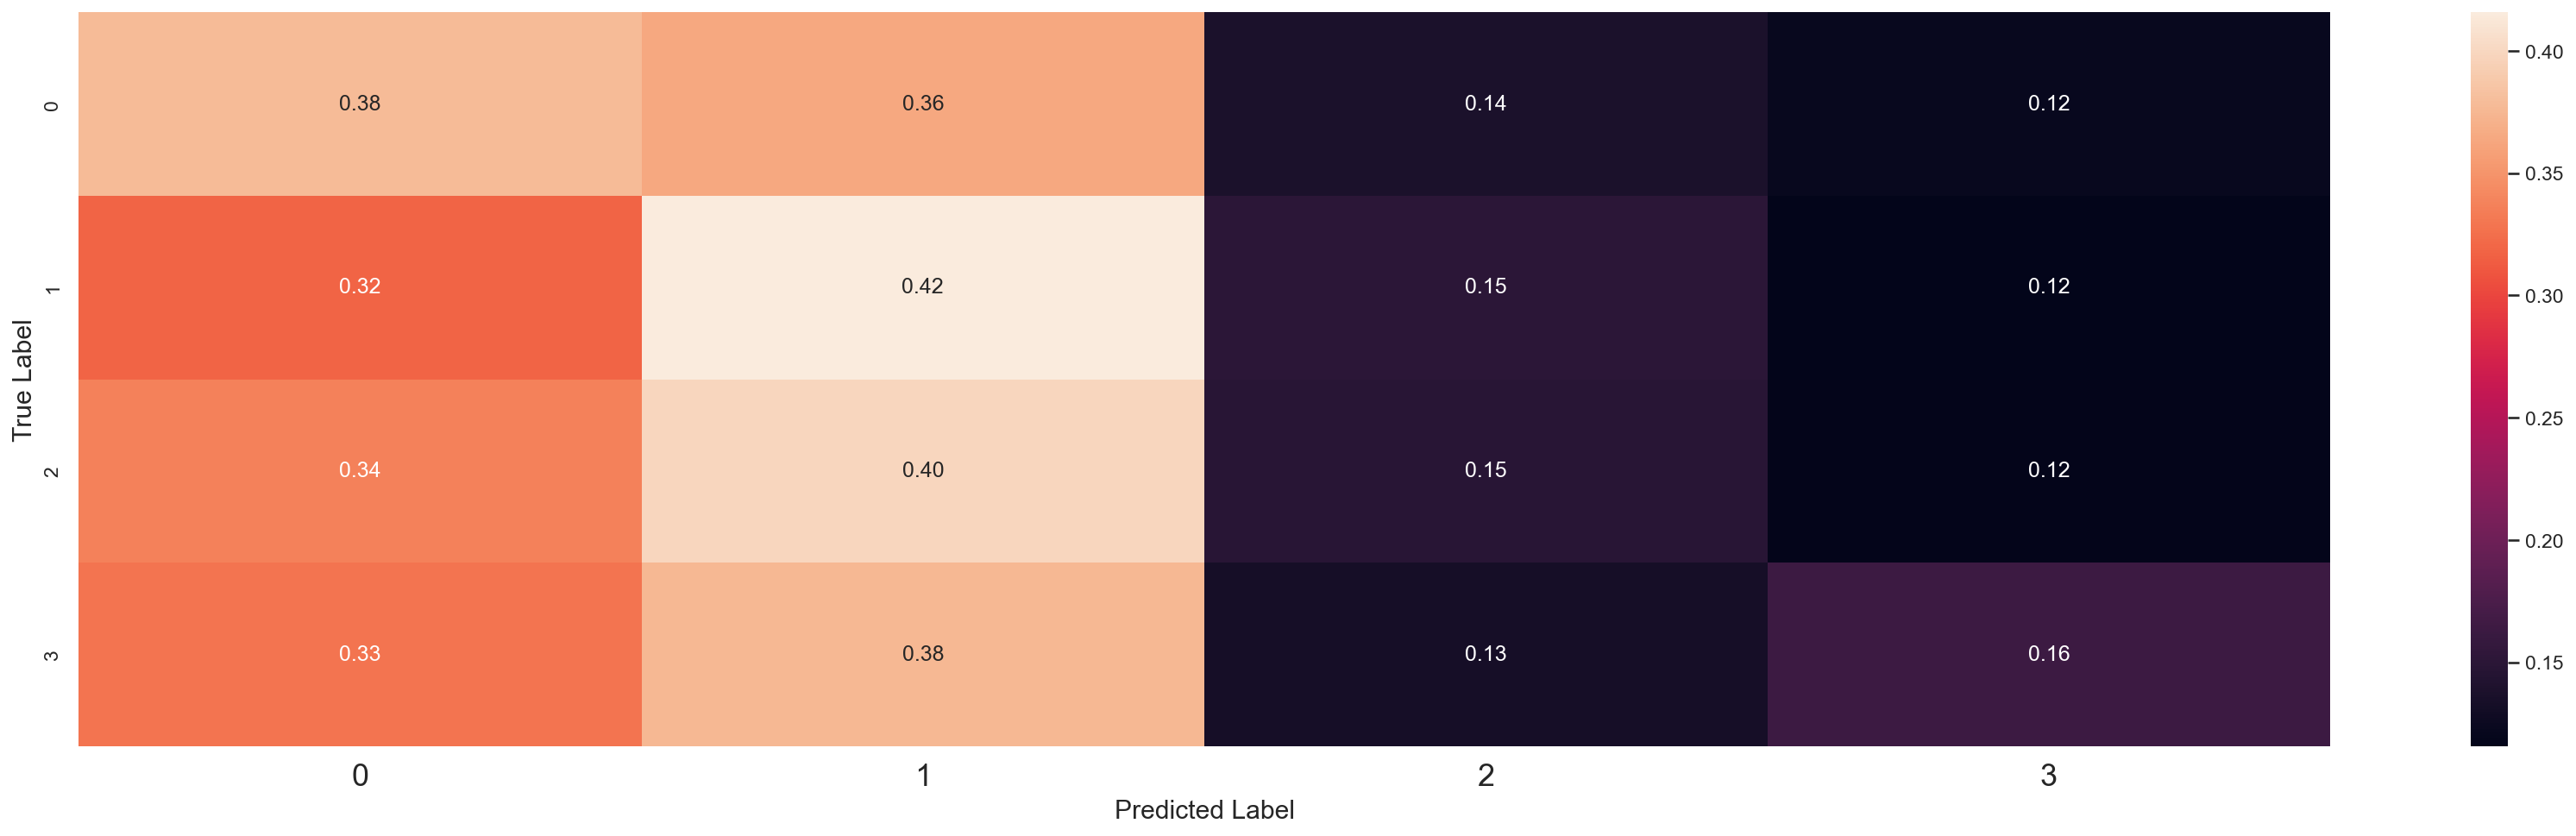

In [362]:
# normalising and viewing the confusion matrix
sub_knn_conf_matrix_norm = sub_knn_conf_matrix.astype('float') / sub_knn_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_knn_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [363]:
# calculating metrics for the prediction
sub_knn_metrics = metrics.classification_report(y_test, sub_knn_test_prediction,target_names=grouped_categories)
print(sub_knn_metrics)

              precision    recall  f1-score   support

    computer       0.34      0.38      0.36      1955
  recreation       0.27      0.42      0.32      1590
     science       0.26      0.15      0.19      1579
        talk       0.26      0.16      0.20      1301

    accuracy                           0.29      6425
   macro avg       0.28      0.28      0.27      6425
weighted avg       0.28      0.29      0.27      6425



#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [364]:
# initializing grid search cross validation for hyperparameter tuning
neighbour_values=[]
for i in range(1,15):
  neighbour_values.append(i)
weight_values=['uniform', 'distance']
leaf_values = [30,40,50,60]

sub_knn_parameters_dict = dict(n_neighbors=neighbour_values, weights=weight_values,leaf_size=leaf_values)
sub_knn_grid = GridSearchCV(sub_knn_clf, sub_knn_parameters_dict, cv=5, scoring='accuracy')
sub_knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=4),
             param_grid={'leaf_size': [30, 40, 50, 60],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [365]:
# viewing the best parameters
print(sub_knn_grid.best_params_)

{'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}


##### **Retraining**

In [366]:
# reinitializing and refitting the KNN Classifier
sub_knn_ht_clf = KNeighborsClassifier(n_neighbors=2,weights='distance',leaf_size=30)
sub_knn_ht_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2, weights='distance')

##### **Revaluation**

In [367]:
# recalculating training accuracy
sub_knn_ht_train_prediction = sub_knn_ht_clf.predict(X_train)
sub_knn_ht_train_accuracy = accuracy_score(y_train,sub_knn_ht_train_prediction)
print("Training Accuracy with tuned Hyperparameters:",sub_knn_ht_train_accuracy*100)
sub_category_train_accuracy.append(sub_knn_ht_train_accuracy)

# recalculating testing accuracy
sub_knn_ht_test_prediction = sub_knn_ht_clf.predict(X_test)
sub_knn_ht_test_accuracy = accuracy_score(y_test, sub_knn_ht_test_prediction)
print("Testing Accuracy with tuned Hyperparameters:",sub_knn_ht_test_accuracy*100)
sub_category_test_accuracy.append(sub_knn_ht_test_accuracy)

Training Accuracy with tuned Hyperparameters: 97.83419689119171
Testing Accuracy with tuned Hyperparameters: 29.556420233463037


In [368]:
# creating the confusion matrix
sub_knn_ht_conf_matrix = confusion_matrix(y_test, sub_knn_ht_test_prediction)

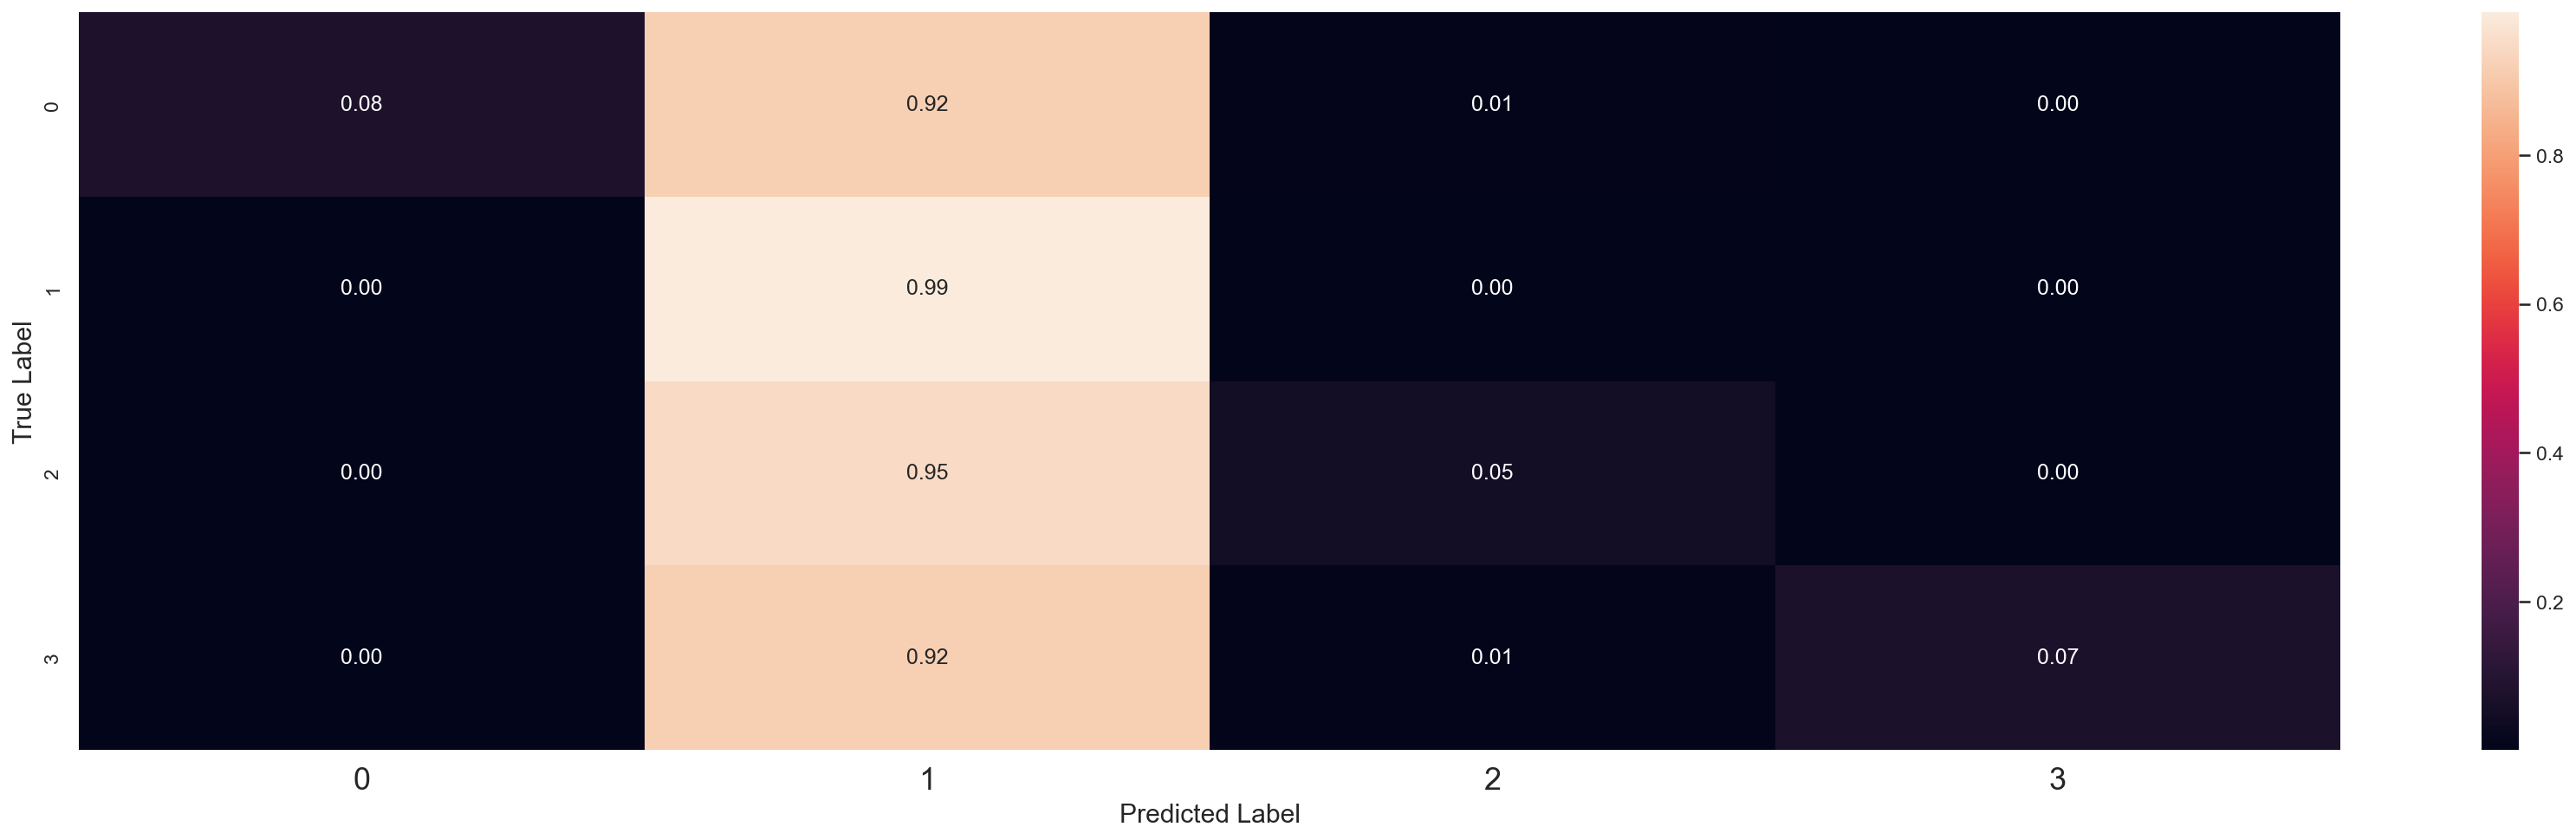

In [369]:
# renormalising and reviewing the confusion matrix
sub_knn_ht_conf_matrix_norm = sub_knn_ht_conf_matrix.astype('float') / sub_knn_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_knn_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [370]:
# calculating metrics for the prediction
sub_knn_ht_metrics = metrics.classification_report(y_test, sub_knn_ht_test_prediction,target_names=grouped_categories)
print(sub_knn_ht_metrics)

              precision    recall  f1-score   support

    computer       0.95      0.08      0.14      1955
  recreation       0.26      0.99      0.41      1590
     science       0.74      0.05      0.09      1579
        talk       0.92      0.07      0.14      1301

    accuracy                           0.30      6425
   macro avg       0.72      0.30      0.20      6425
weighted avg       0.72      0.30      0.20      6425



### **Support Vector Machine Classifier**

#### **Training**

In [371]:
# initializing and fitting the SVM classifier
sub_svm_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, multi_class='ovr', max_iter=1000)
sub_svm_clf.fit(X_train,y_train)

LinearSVC(dual=False)

#### **Evaluation**

In [372]:
# calculating training accuracy
sub_svm_train_prediction = sub_svm_clf.predict(X_train)
sub_svm_train_accuracy = accuracy_score(y_train,sub_svm_train_prediction)
print("Training Accuracy:",sub_svm_train_accuracy*100)
sub_category_train_accuracy.append(sub_svm_train_accuracy)

# calculating testing accuracy
sub_svm_test_prediction = sub_svm_clf.predict(X_test)
sub_svm_test_accuracy = accuracy_score(y_test, sub_svm_test_prediction)
print("Testing Accuracy:",sub_svm_test_accuracy*100)
sub_category_test_accuracy.append(sub_svm_test_accuracy)

Training Accuracy: 97.62694300518135
Testing Accuracy: 83.67315175097276


In [373]:
# creating the confusion matrix
sub_svm_conf_matrix = confusion_matrix(y_test, sub_svm_test_prediction)

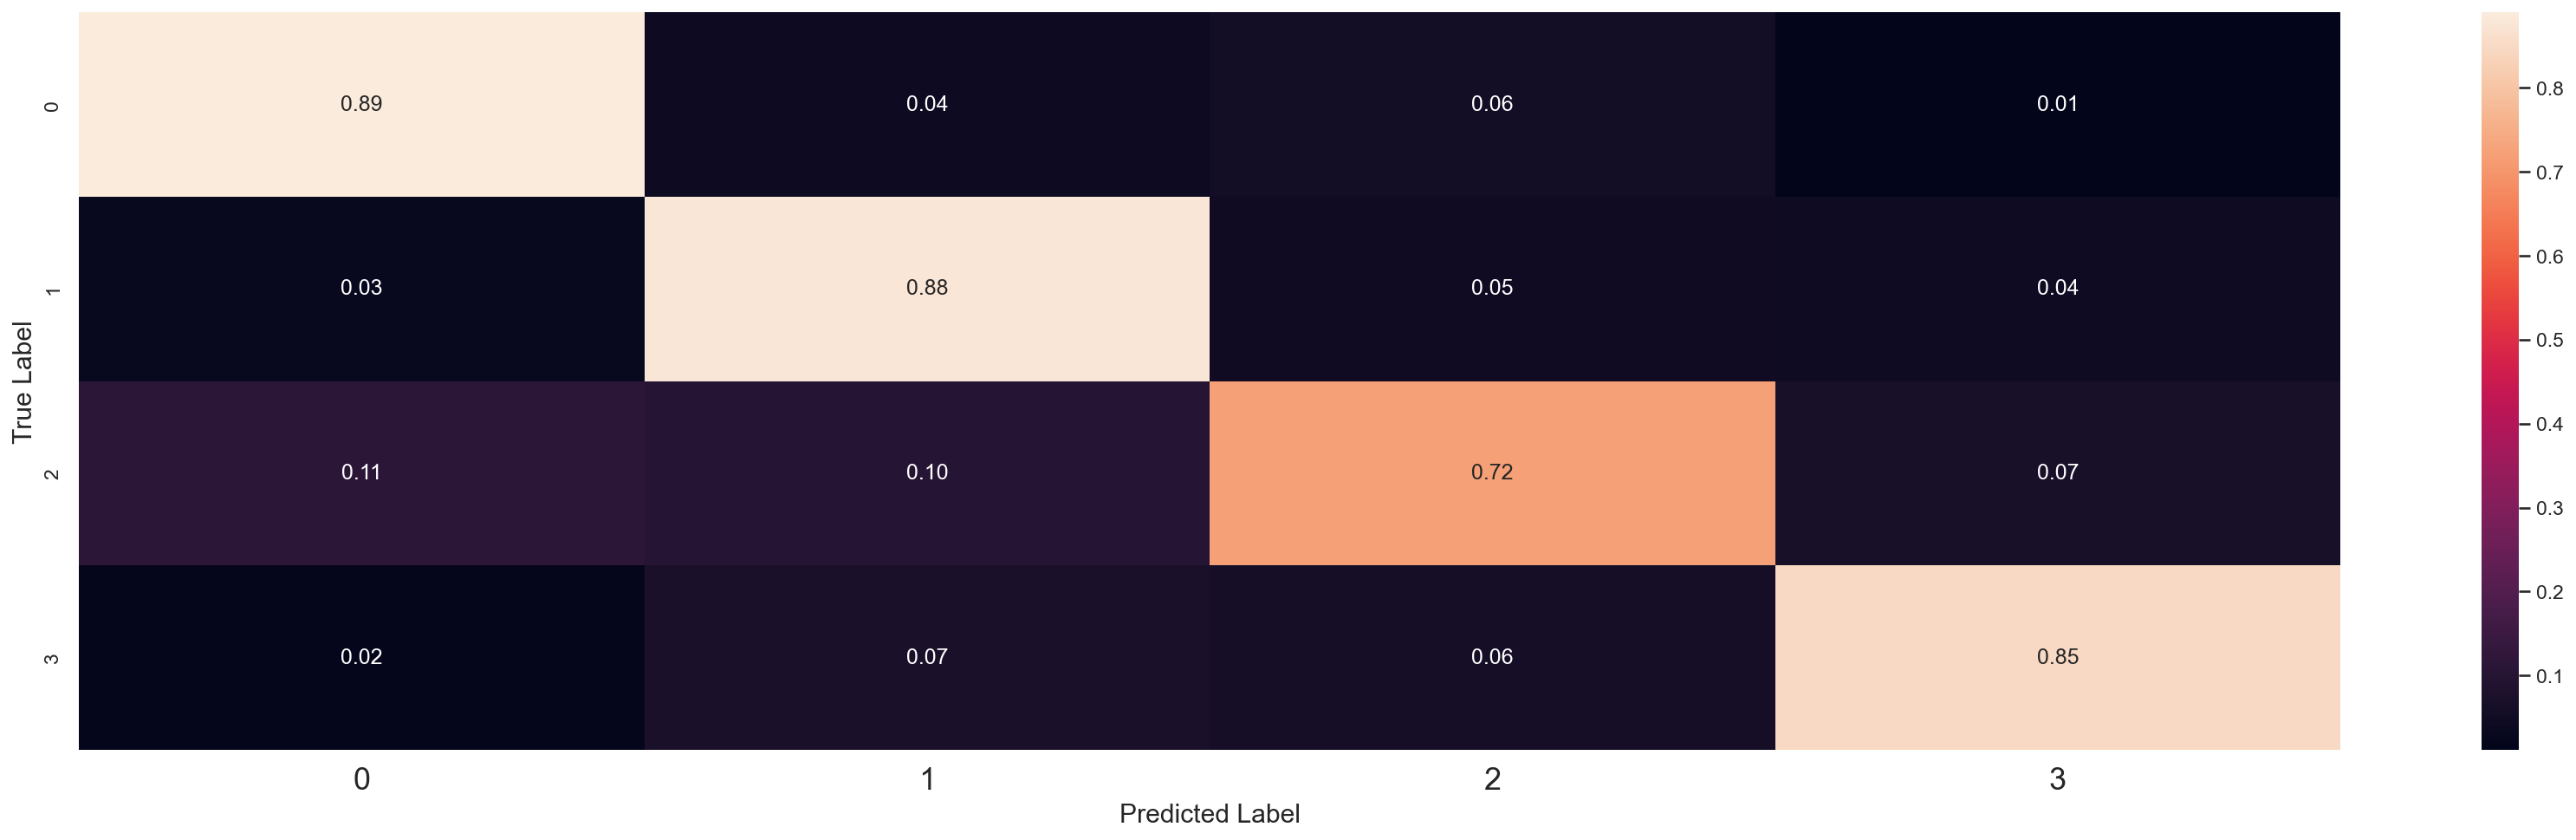

In [374]:
# normalizing and viewing the confusion matrix
sub_svm_conf_matrix_norm = sub_svm_conf_matrix.astype('float') / sub_svm_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_svm_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [375]:
# calculating metrics for the prediction
sub_svm_metrics = metrics.classification_report(y_test, sub_svm_test_prediction,target_names=grouped_categories)
print(sub_svm_metrics)

              precision    recall  f1-score   support

    computer       0.87      0.89      0.88      1955
  recreation       0.81      0.88      0.84      1590
     science       0.81      0.72      0.76      1579
        talk       0.85      0.85      0.85      1301

    accuracy                           0.84      6425
   macro avg       0.83      0.83      0.83      6425
weighted avg       0.84      0.84      0.84      6425



#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [376]:
# intializing grid search cross validation for hyperparameter tuning
penalty_values=['l1','l2']
tolerance_values = [0.1,0.001]
C_values=[2,5,10]
sub_svm_parameters_dict = dict(penalty=penalty_values, C=C_values, tol=tolerance_values)
sub_svm_grid = GridSearchCV(sub_svm_clf, sub_svm_parameters_dict, cv=5, scoring='accuracy')
sub_svm_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False),
             param_grid={'C': [2, 5, 10], 'penalty': ['l1', 'l2'],
                         'tol': [0.1, 0.001]},
             scoring='accuracy')

In [377]:
# viewing the best parameters
print(sub_svm_grid.best_params_)

{'C': 2, 'penalty': 'l2', 'tol': 0.1}


##### **Retraining**

In [378]:
# reinitializing and refitting the SVM classifier
sub_svm_ht_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, multi_class='ovr', max_iter=1000, C=2, tol=0.1)
sub_svm_ht_clf.fit(X_train,y_train)

LinearSVC(C=2, dual=False, tol=0.1)

##### **Revaluation**

In [379]:
# recalculating training accuracy
sub_svm_ht_train_prediction = sub_svm_ht_clf.predict(X_train)
sub_svm_ht_train_accuracy = accuracy_score(y_train,sub_svm_ht_train_prediction)
print("Training Accuracy with tuned hyperparameters:",sub_svm_ht_train_accuracy*100)
sub_category_train_accuracy.append(sub_svm_ht_train_accuracy)

# recalculating testing accuracy
sub_svm_ht_test_prediction = sub_svm_ht_clf.predict(X_test)
sub_svm_ht_test_accuracy = accuracy_score(y_test, sub_svm_ht_test_prediction)
print("Testing Accuracy with tuned hyperparameters:",sub_svm_ht_test_accuracy*100)
sub_category_test_accuracy.append(sub_svm_ht_test_accuracy)

Training Accuracy with tuned hyperparameters: 96.69430051813471
Testing Accuracy with tuned hyperparameters: 83.75097276264592


In [380]:
# creating the confusion matrix
sub_svm_ht_conf_matrix = confusion_matrix(y_test, sub_svm_ht_test_prediction)

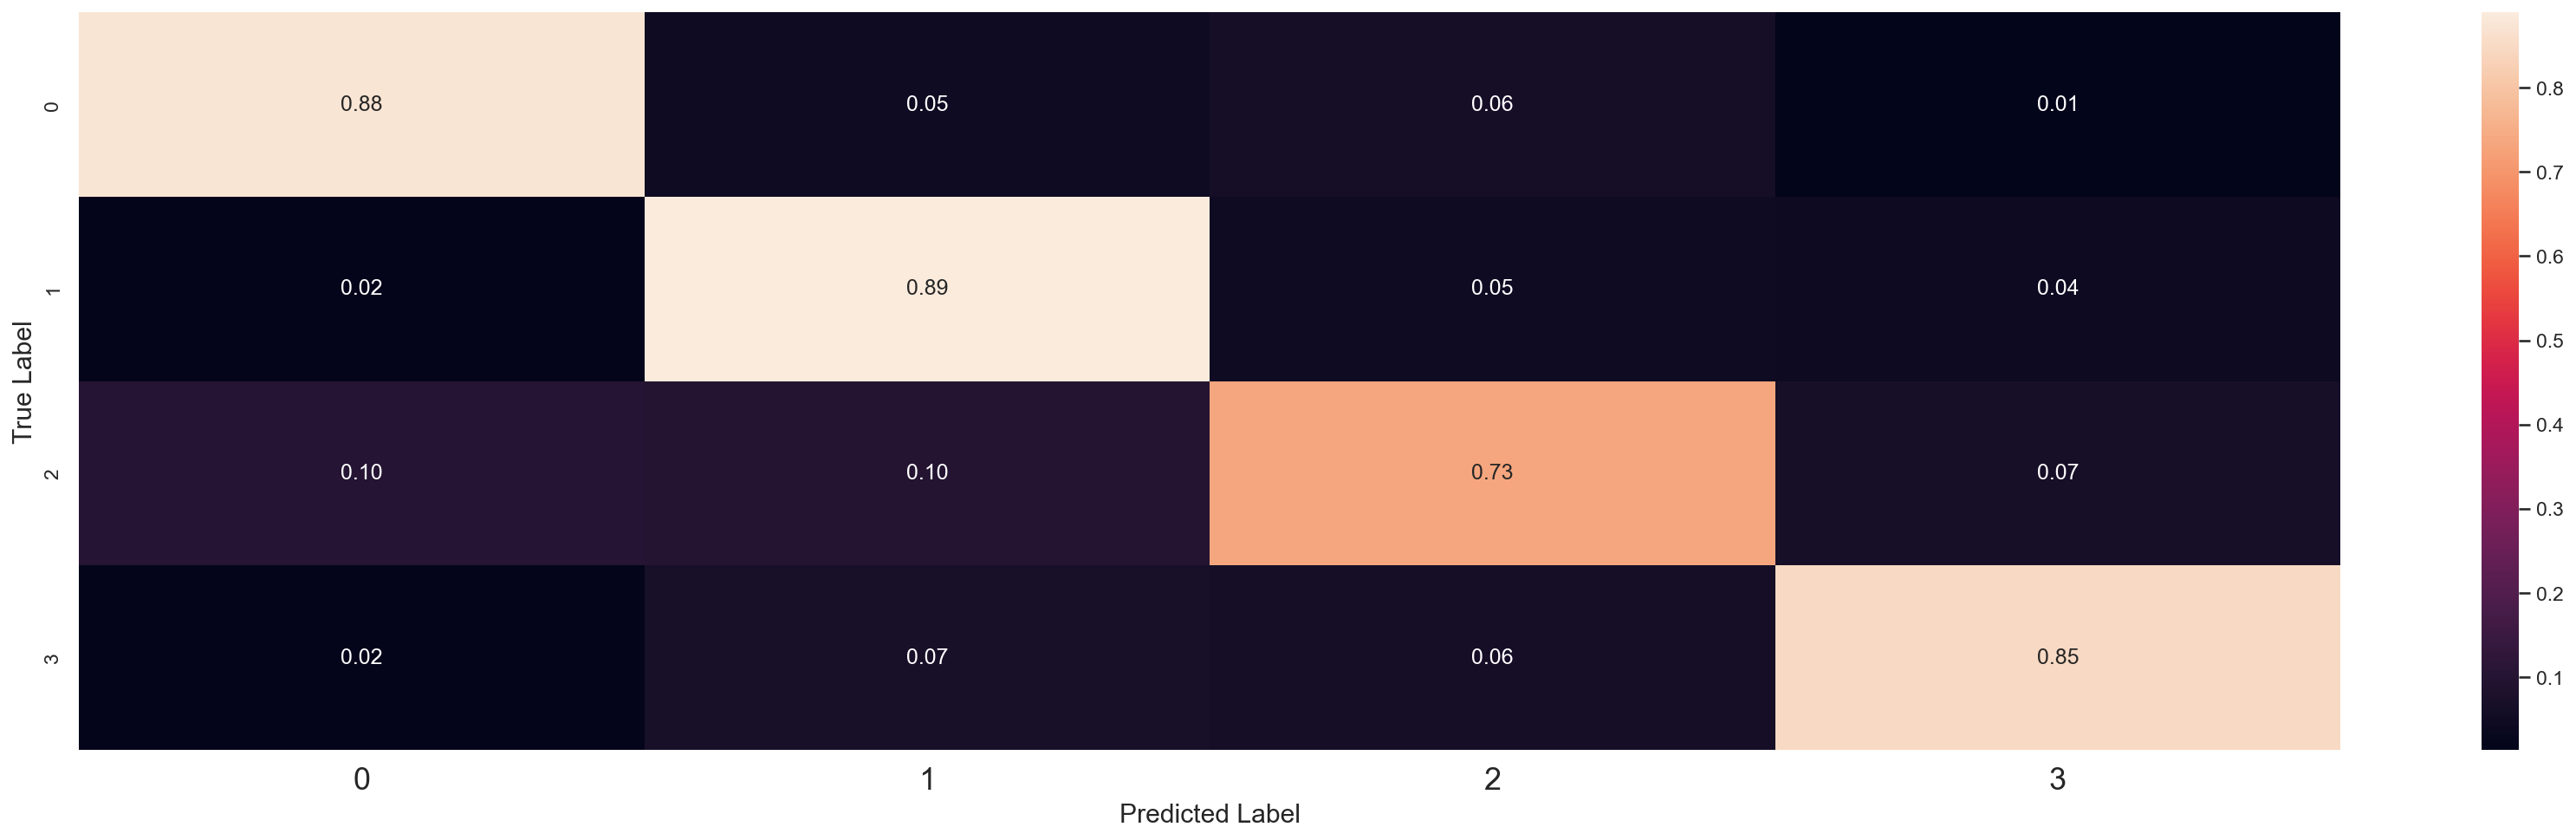

In [381]:
# renormalizing and reviewing the confusion matrix
sub_svm_ht_conf_matrix_norm = sub_svm_ht_conf_matrix.astype('float') / sub_svm_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_svm_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [382]:
# calculating metrics for the prediction
sub_svm_ht_metrics = metrics.classification_report(y_test, sub_svm_ht_test_prediction, target_names=grouped_categories)
print(sub_svm_ht_metrics)

              precision    recall  f1-score   support

    computer       0.89      0.88      0.88      1955
  recreation       0.81      0.89      0.85      1590
     science       0.80      0.73      0.77      1579
        talk       0.84      0.85      0.84      1301

    accuracy                           0.84      6425
   macro avg       0.84      0.84      0.83      6425
weighted avg       0.84      0.84      0.84      6425



### **Multinomial Naive Bayes Classifier**

#### **Training**

In [383]:
# initializing and fitting the Multinomial Naive Bayes Classifier
sub_mnb_clf = MultinomialNB(alpha=0.1)
sub_mnb_clf.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

#### **Evaluation**

In [384]:
# calculating training accuracy
sub_mnb_train_prediction = sub_mnb_clf.predict(X_train)
sub_mnb_train_accuracy = accuracy_score(y_train, sub_mnb_train_prediction)
print("Training Accuracy:",sub_mnb_train_accuracy*100)
sub_category_train_accuracy.append(sub_mnb_train_accuracy)

# calculating the testing accuracy 
sub_mnb_test_prediction = sub_mnb_clf.predict(X_test)
sub_mnb_test_accuracy= accuracy_score(y_test, sub_mnb_test_prediction)
print("Testing Accuracy:",sub_mnb_test_accuracy*100)
sub_category_test_accuracy.append(sub_mnb_test_accuracy)

Training Accuracy: 93.25388601036269
Testing Accuracy: 84.8249027237354


In [385]:
# creating the confusion matrix
sub_mnb_conf_matrix = confusion_matrix(y_test, sub_mnb_test_prediction)

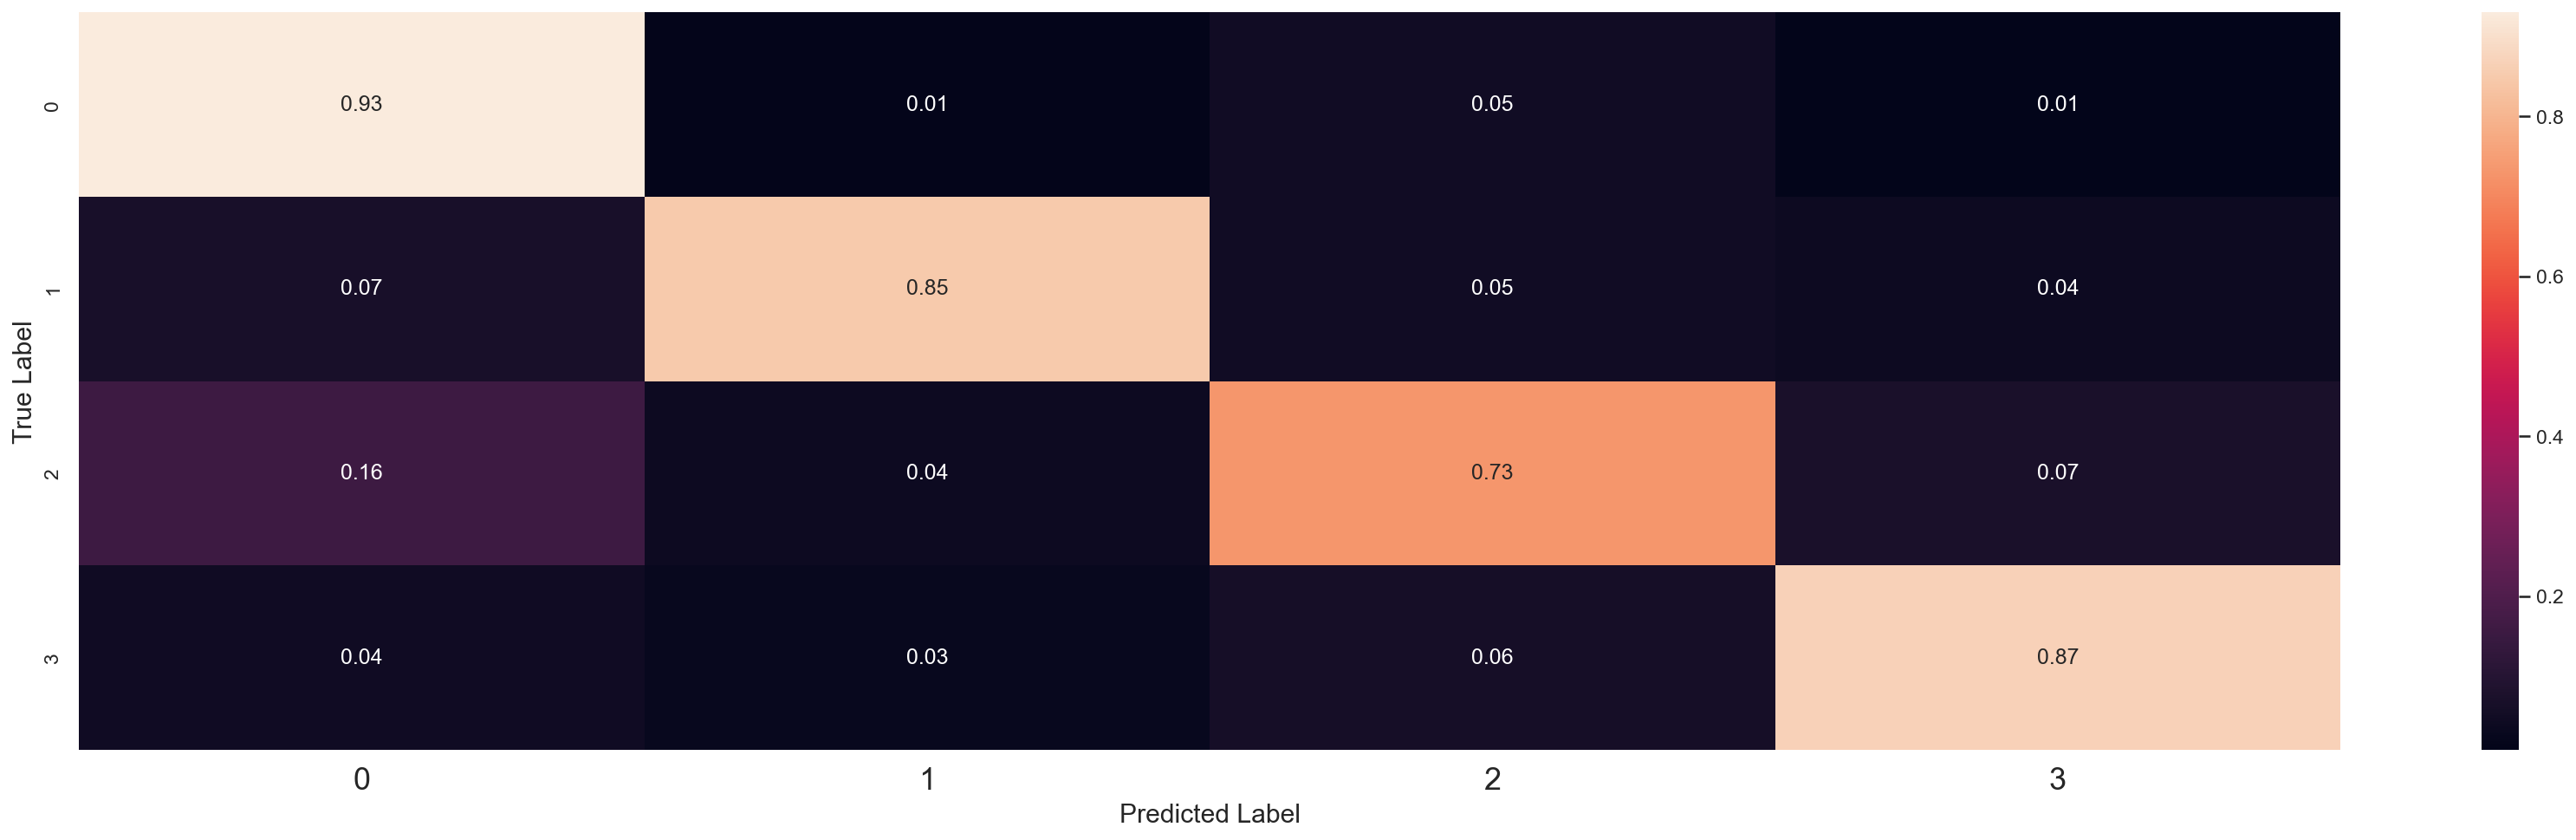

In [386]:
# normalising and viewing the confusion matrix
sub_mnb_conf_matrix_norm = sub_mnb_conf_matrix.astype('float') / sub_mnb_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_mnb_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [387]:
# calculating metrics for the prediction
sub_mnb_metrics = metrics.classification_report(y_test, sub_mnb_test_prediction,target_names=grouped_categories)
print(sub_mnb_metrics)

              precision    recall  f1-score   support

    computer       0.82      0.93      0.87      1955
  recreation       0.92      0.85      0.88      1590
     science       0.82      0.73      0.77      1579
        talk       0.85      0.87      0.86      1301

    accuracy                           0.85      6425
   macro avg       0.85      0.84      0.85      6425
weighted avg       0.85      0.85      0.85      6425



#### **Tuning Hyperparameters**

##### **Grid Search Cross Validation**

In [388]:
# initializing Grid Search Cross Validation for hyperparameter tuning
alpha_range = [0.0001, 0.001, 0.01, 0.2, 0.5, 0.7, 1, 2, 5, 8, 9, 10]
fit_vals=[True,False]
sub_mnb_parameters_dict = dict(alpha=alpha_range,fit_prior=fit_vals)
sub_mnb_grid = GridSearchCV(sub_mnb_clf, sub_mnb_parameters_dict, cv=5, scoring='accuracy')
sub_mnb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(alpha=0.1),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.2, 0.5, 0.7, 1, 2, 5,
                                   8, 9, 10],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [389]:
# viewing the best parameters
sub_mnb_grid.best_params_

{'alpha': 0.2, 'fit_prior': False}

##### **Retraining**

In [390]:
# reinitializing and refitting the Multinomial Naive Bayes Classifier
sub_mnb_ht_clf = MultinomialNB(alpha=0.2,fit_prior=False)
sub_mnb_ht_clf.fit(X_train,y_train)

MultinomialNB(alpha=0.2, fit_prior=False)

##### **Revaluation**

In [391]:
# recalculating training accuracy
sub_mnb_ht_train_prediction = sub_mnb_ht_clf.predict(X_train)
sub_mnb_ht_train_accuracy = accuracy_score(y_train, sub_mnb_ht_train_prediction)
print("Training Accuracy with tuned hyperparameters:",sub_mnb_ht_train_accuracy*100)
sub_category_train_accuracy.append(sub_mnb_ht_train_accuracy)

# recalculating testing accuracy
sub_mnb_ht_test_prediction = sub_mnb_ht_clf.predict(X_test)
sub_mnb_ht_test_accuracy= accuracy_score(y_test, sub_mnb_ht_test_prediction)
print("Testing Accuracy with tuned hyperparameters:",sub_mnb_ht_test_accuracy*100)
sub_category_test_accuracy.append(sub_mnb_ht_test_accuracy)

Training Accuracy with tuned hyperparameters: 92.860103626943
Testing Accuracy with tuned hyperparameters: 85.01167315175098


In [392]:
# creating the confusion matrix
sub_mnb_ht_conf_matrix = confusion_matrix(y_test, sub_mnb_ht_test_prediction)

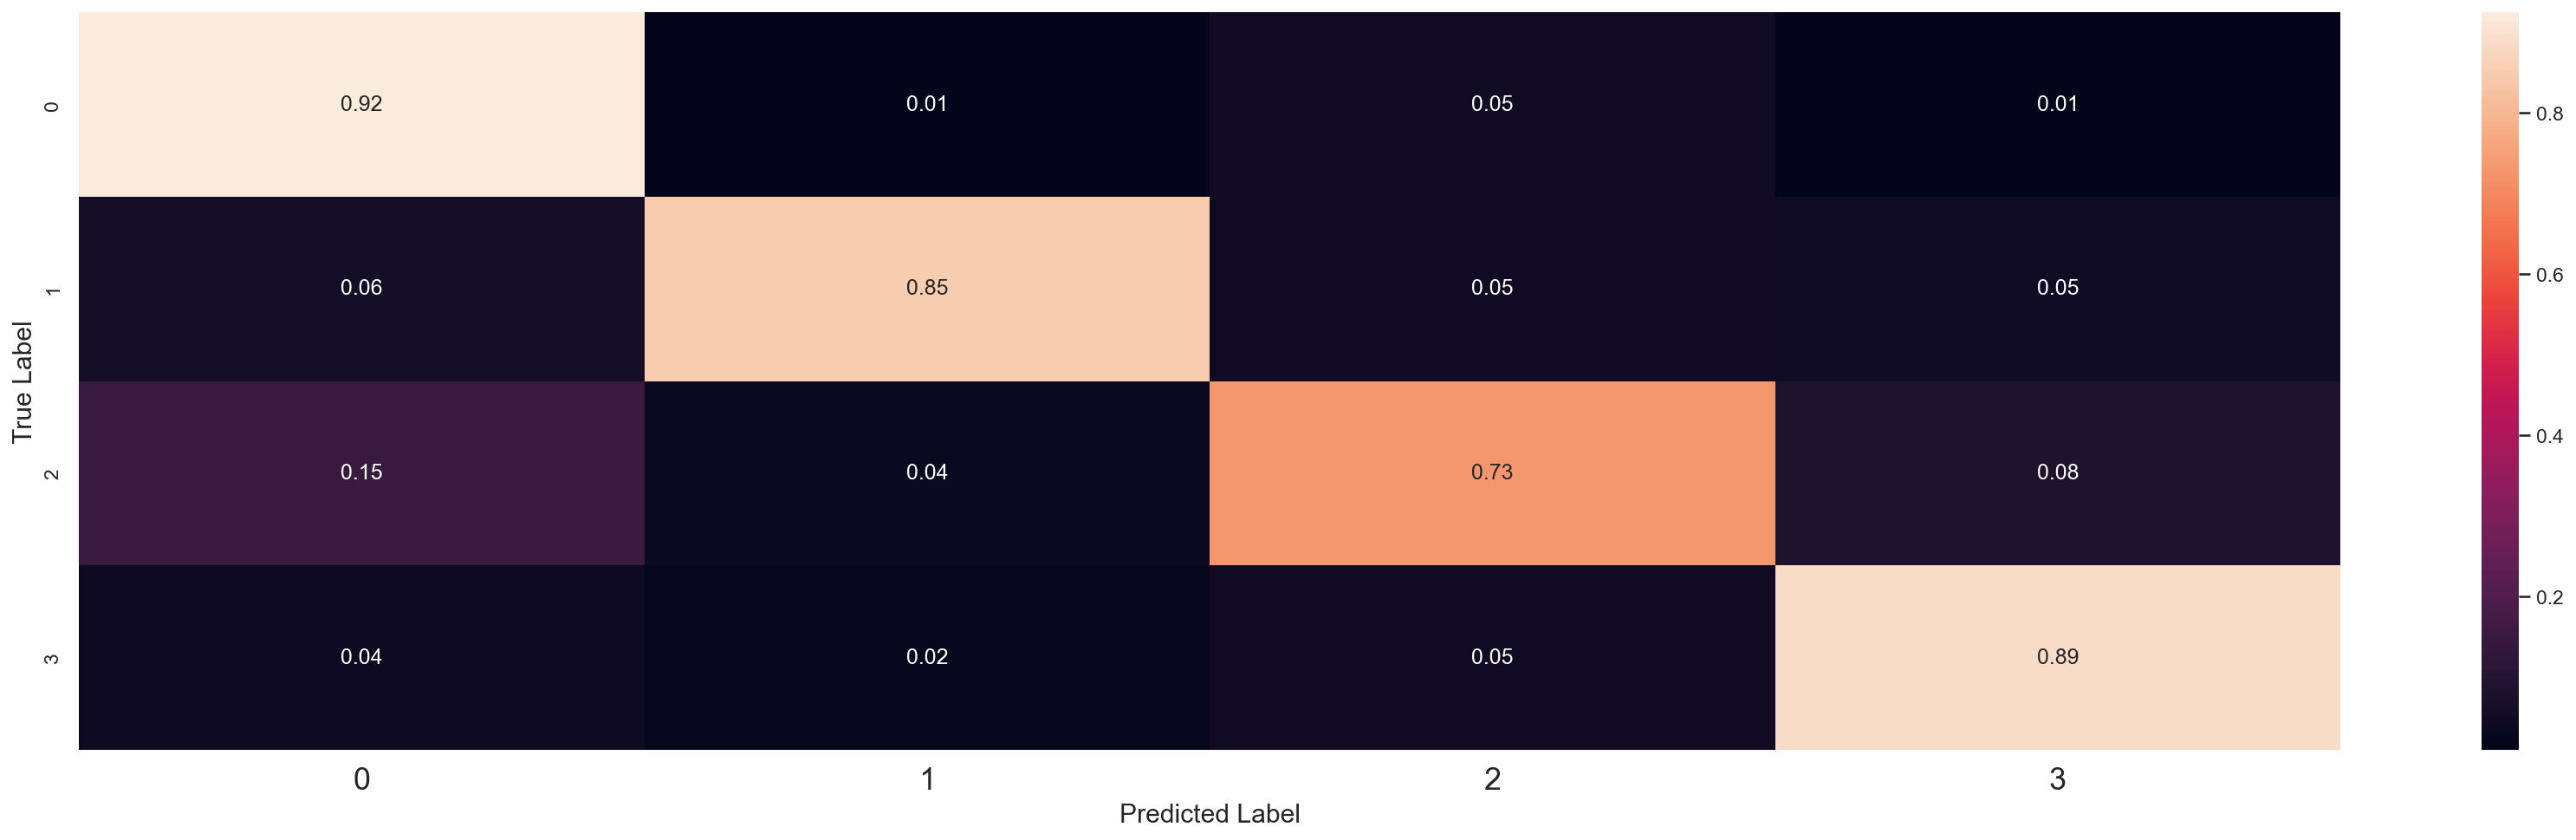

In [393]:
# renormalising and viewing the confusion matrix
sub_mnb_ht_conf_matrix_norm = sub_mnb_ht_conf_matrix.astype('float') / sub_mnb_ht_conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(sub_mnb_ht_conf_matrix_norm, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [394]:
# recalculating metrics for the prediction
sub_mnb_ht_metrics = metrics.classification_report(y_test, sub_mnb_ht_test_prediction,target_names=grouped_categories)
print(sub_mnb_ht_metrics)

              precision    recall  f1-score   support

    computer       0.83      0.92      0.87      1955
  recreation       0.92      0.85      0.88      1590
     science       0.83      0.73      0.78      1579
        talk       0.84      0.89      0.86      1301

    accuracy                           0.85      6425
   macro avg       0.85      0.85      0.85      6425
weighted avg       0.85      0.85      0.85      6425



## **Comparing Accuracies**

In [395]:
# comparing training and testing accuracies
sub_model_acc_compare = pd.DataFrame({'Algorithm' : classification_models, 'Training_Accuracy' : sub_category_train_accuracy, 'Testing_Accuracy' : sub_category_test_accuracy})
sub_model_acc_compare.sort_values(by='Testing_Accuracy', ascending=False).style.hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

From the table above, following are the observations:

1. The testing set accuracy of all the models increases after tuning the hyper-parameters.
2. With a testing set accuracy of 85.01%, the hyper-tuned MNB outperforms all the other models and is the most reliable classifier for this dataset. It is able to classify the documents better than other classifiers.
3. The accuracies of SVM and its hyper-tuned version closely follow up. 
4. The training set accuracy of the hyper-tuned KNN is the best but it doesn’t perform well on the testing set. The performance of the vanilla KNN lags far behind as it achieves an accuracy of just 28.9% on the testing set.
5. The training set accuracy of all the models is greater than the testing set accuracy. This means that the models are overfitting as they has learned the noise of the training documents very well.

[Text(0, 0, 'K Nearest Neighbor'),
 Text(0, 0, 'K Nearest Neighbor Hypertuned'),
 Text(0, 0, 'Support Vector Machine'),
 Text(0, 0, 'Support Vector Machine Hypertuned'),
 Text(0, 0, 'Multinomial Naive Bayes'),
 Text(0, 0, 'Multinomial Naive Bayes Hypertuned')]

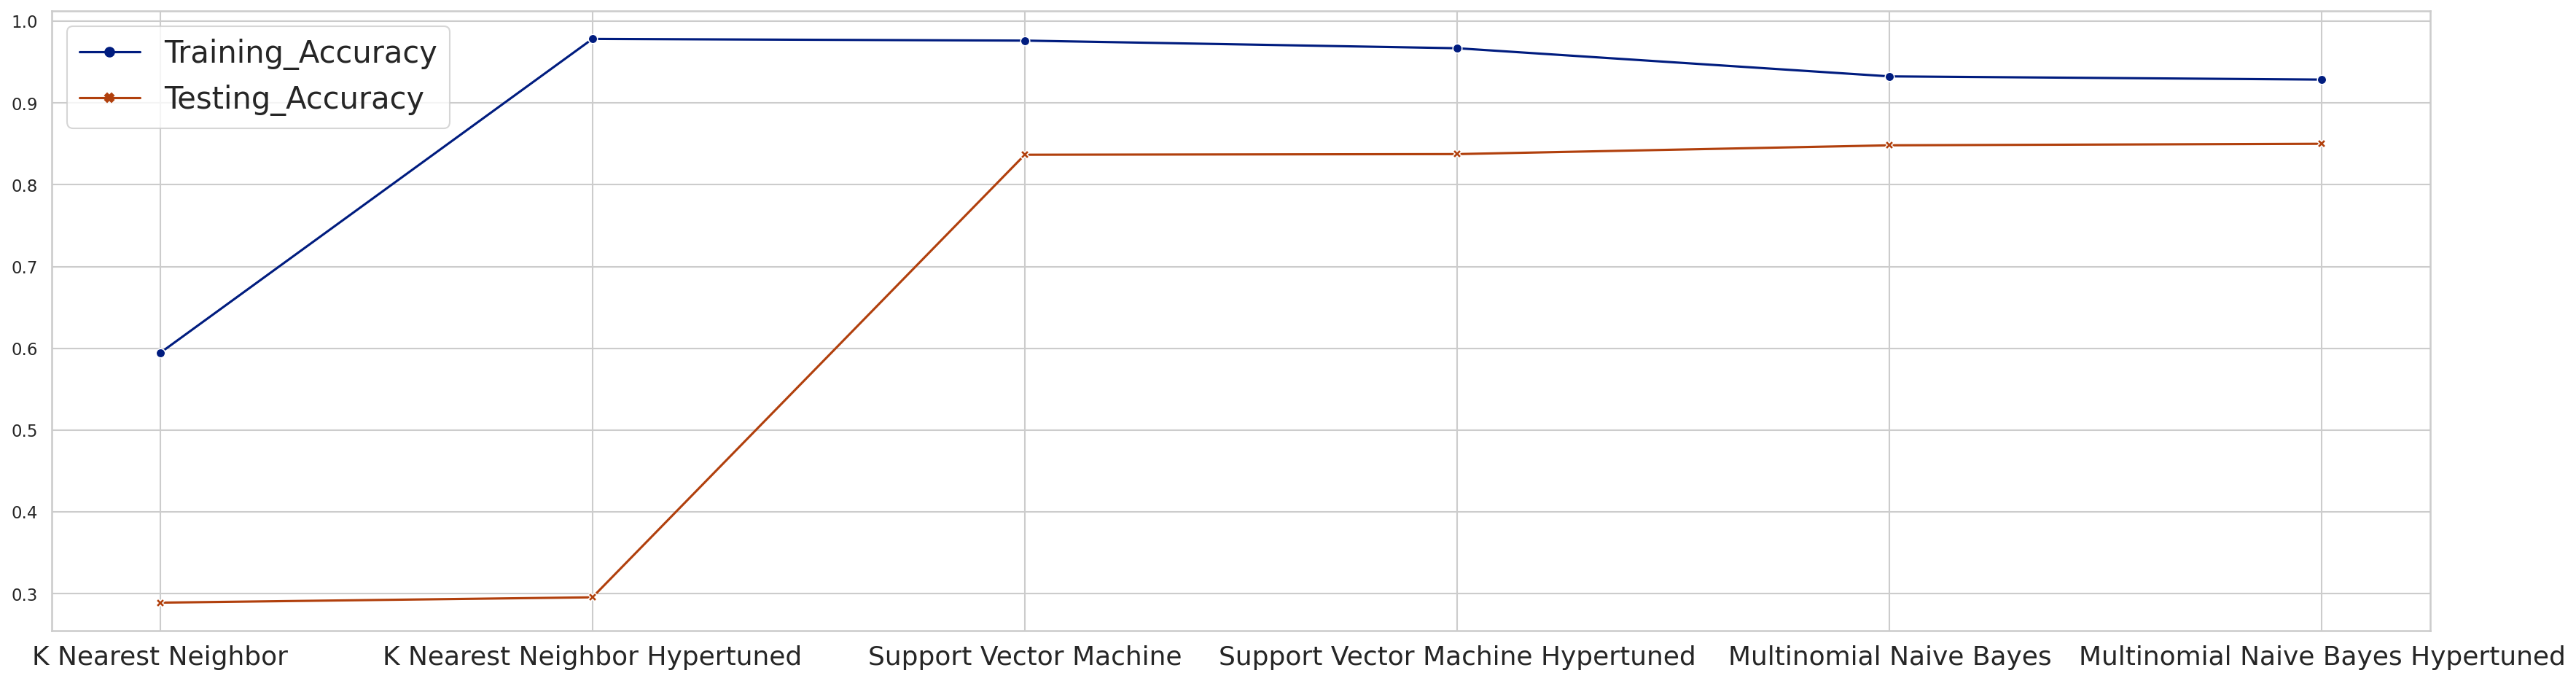

In [ ]:
# visualizing the training and testing accuracies
ax = sns.lineplot(data=[sub_model_acc_compare['Training_Accuracy'], sub_model_acc_compare['Testing_Accuracy']], dashes=False, markers=True)
ax.set_xticks(range(len(sub_model_acc_compare['Algorithm'])))
ax.set_xticklabels(sub_model_acc_compare['Algorithm'])

**Plot Analysis**

The line plot illustrates the training set and testing set accuracy curves for all the models including their hyper-tuned versions. The gap between both the curves indicates overfitting. The KNN classifier overfits most to the training documents, where as the MNB classifer overfits the least. The SVM classifier overfits slightly more than the MNB classifier.

## **Comparing Metrics**

In [ ]:
# calculating all the performance metrics
sub_precision_score.extend([metrics.precision_score(y_test, sub_knn_test_prediction,average="weighted")*100,
                           metrics.precision_score(y_test, sub_knn_ht_test_prediction,average="weighted")*100,
                           metrics.precision_score(y_test, sub_svm_test_prediction,average="weighted")*100,
                           metrics.precision_score(y_test, sub_svm_ht_test_prediction,average="weighted")*100,
                           metrics.precision_score(y_test, sub_mnb_test_prediction,average="weighted")*100,
                           metrics.precision_score(y_test, sub_mnb_ht_test_prediction,average="weighted")*100])

sub_recall_score.extend([metrics.recall_score(y_test, sub_knn_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, sub_knn_ht_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, sub_svm_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, sub_svm_ht_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, sub_mnb_test_prediction,average="weighted")*100,
                         metrics.recall_score(y_test, sub_mnb_ht_test_prediction,average="weighted")*100])

sub_f1_score.extend([metrics.f1_score(y_test, sub_knn_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, sub_knn_ht_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, sub_svm_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, sub_svm_ht_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, sub_mnb_test_prediction,average="weighted")*100,
                     metrics.f1_score(y_test, sub_mnb_ht_test_prediction,average="weighted")*100])

In [ ]:
# displaying all the performance metrics
sub_comp_metric = pd.DataFrame({'Model' : ['K Nearest Neighbor', 'K Nearest Neighbor Hypertuned', 'Support Vector Machine', 'Support Vector Machine Hypertuned', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes Hypertuned'],
                       'Precision' : sub_precision_score,
                       'Recall' : sub_recall_score,
                       'F1' : sub_f1_score,
                       'Test_Accuracy' : sub_category_test_accuracy},
                       index=["", "", "","","","4 Clubbed Groups"])

sub_comp_metric.sort_values(by='Test_Accuracy', ascending=False, inplace=True)
sub_comp_metric

Model  Precision     Recall  \
4 Clubbed Groups  Multinomial Naive Bayes Hypertuned  85.186507  85.011673   
                             Multinomial Naive Bayes  85.012906  84.824903   
                   Support Vector Machine Hypertuned  83.773891  83.750973   
                              Support Vector Machine  83.636989  83.673152   
                       K Nearest Neighbor Hypertuned  71.928645  29.556420   
                                  K Nearest Neighbor  28.249116  28.902724   

                         F1  Test_Accuracy  
4 Clubbed Groups  84.888599       0.850117  
                  84.707742       0.848249  
                  83.672813       0.837510  
                  83.555545       0.836732  
                  19.509310       0.295564  
                  27.535885       0.289027

The above table shows metrics for the 4 clubbed groups. The detail comparison can be found in the **'Comparing Final Metrics'** section

# **Comparing Final Test Accuracy**

In [ ]:
# comparing the testing accuracies of the 4 clubbed groups and 17 individual groups
final_accuracy_compare = pd.DataFrame({'Algorithm' : classification_models, '17_Individual_Groups_Testing_Accuracy' : all_category_test_accuracy, '4_Clubbed_Groups_Testing_Accuracy' : sub_category_test_accuracy})
final_accuracy_compare.sort_values(by='4_Clubbed_Groups_Testing_Accuracy', ascending=False).style.hide_index()

From the table above, following are the observations:

1. All the models trained and tested using the 4 clubbed groups perform better than their 17 individual group counterparts.
2. For this dataset, all the models are able to classify the documents with greater accuracy when the documents are clubbed under 4 umbrella topics than when there are 17 individual topics.
3. The hyper-tuned MNB classifier and the hyper-tuned SVM classifier achieved a significant accuracy gain (approximately 19%) when it was trained and tested using the documents in 4 clubbed groups.
4. Even though the vanilla KNN classifier is the least impressive model, it achieves a massive accuracy gain (approximately 220%) when it is trained and tested using the documents in 4 clubbed groups.

[Text(0, 0, 'K Nearest Neighbor'),
 Text(0, 0, 'K Nearest Neighbor Hypertuned'),
 Text(0, 0, 'Support Vector Machine'),
 Text(0, 0, 'Support Vector Machine Hypertuned'),
 Text(0, 0, 'Multinomial Naive Bayes'),
 Text(0, 0, 'Multinomial Naive Bayes Hypertuned')]

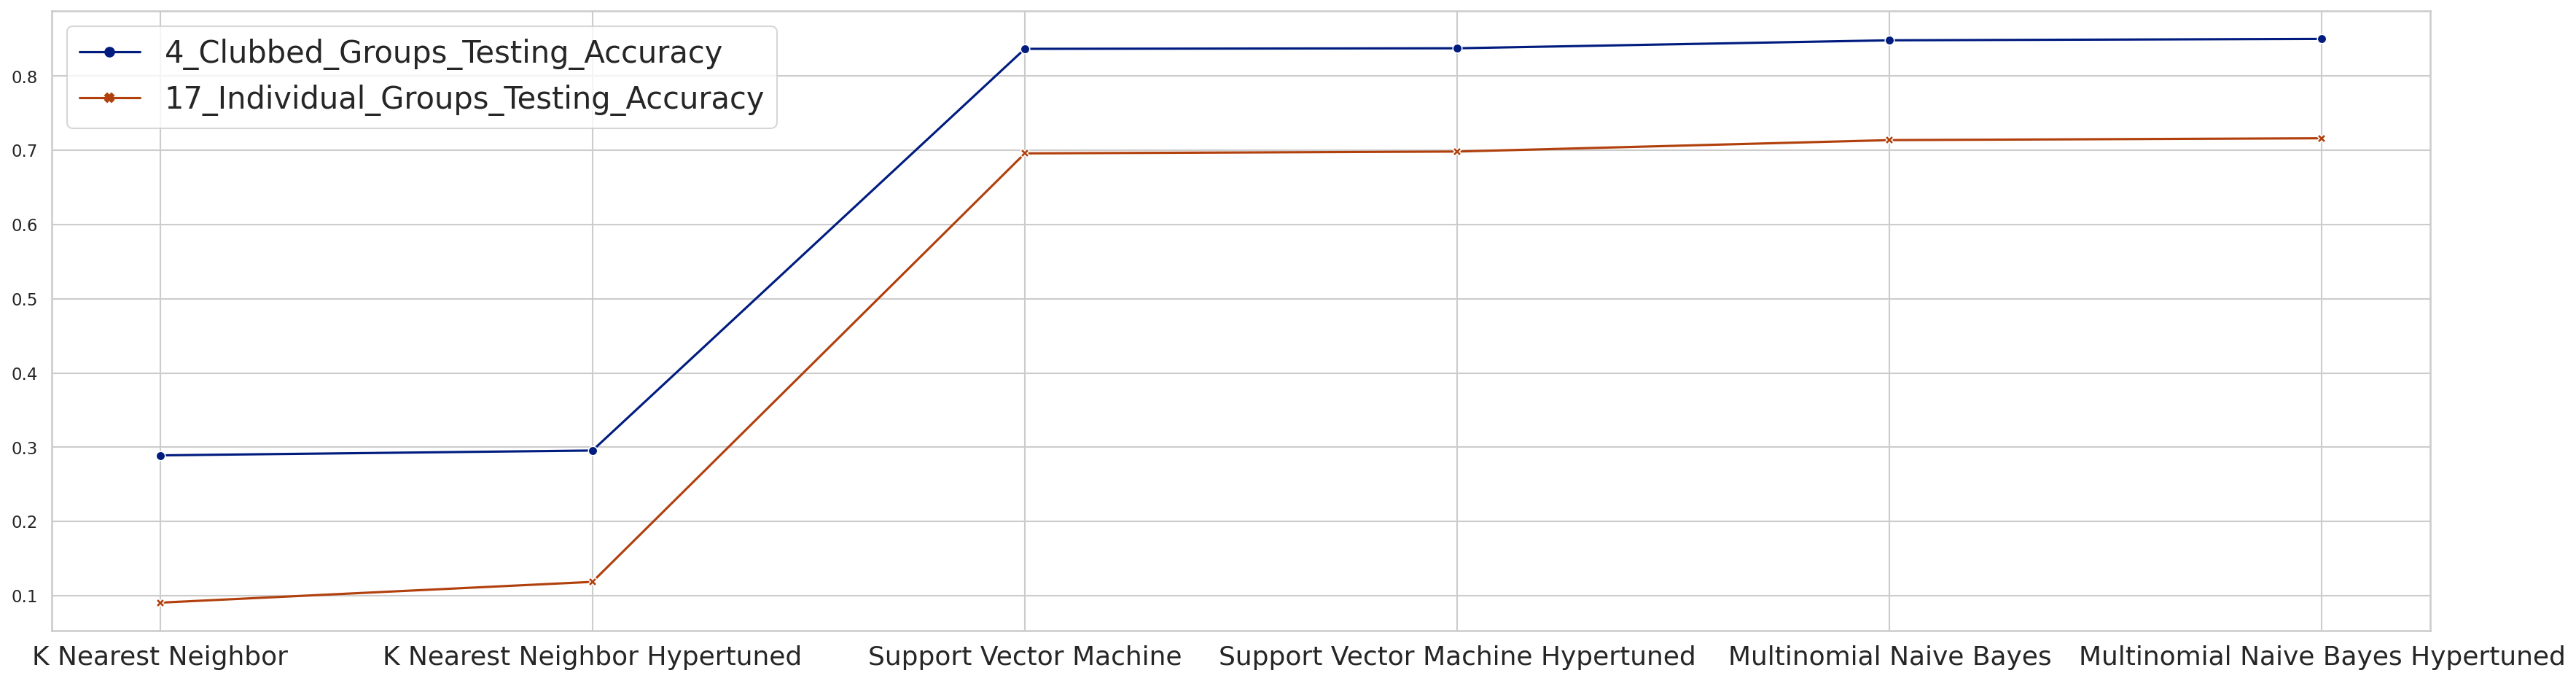

In [ ]:
# visualizing the testing accuracies of the 4 clubbed groups and 17 individual groups
ax = sns.lineplot(data=[final_accuracy_compare['4_Clubbed_Groups_Testing_Accuracy'], final_accuracy_compare['17_Individual_Groups_Testing_Accuracy']], dashes=False, markers=True)
ax.set_xticks(range(len(final_accuracy_compare['Algorithm'])))
ax.set_xticklabels(final_accuracy_compare['Algorithm'])

**Plot Analysis**

The line plot illustrates the testing set accuracy curves for all the models including their hyper-tuned versions.The testing accuracy of the 4 clubbed groups follow the same trend as that of the 17 individual groups. However, the accuracies of the former are significantly better. These accuracy gains signify the importance of more number of documents spread across reduced number of topics.

# **Comparing Final Performance Metrics**

In [ ]:
# comparing the performance metrics of the 4 clubbed groups and 17 individual groups
final_metric_compare = pd.concat([sub_comp_metric, all_comp_metric])
final_metric_compare

Model  Precision  \
4 Clubbed Groups      Multinomial Naive Bayes Hypertuned  85.186507   
                                 Multinomial Naive Bayes  85.012906   
                       Support Vector Machine Hypertuned  83.773891   
                                  Support Vector Machine  83.636989   
                           K Nearest Neighbor Hypertuned  71.928645   
                                      K Nearest Neighbor  28.249116   
17 Indivudial Groups  Multinomial Naive Bayes Hypertuned  73.158085   
                                 Multinomial Naive Bayes  72.087955   
                       Support Vector Machine Hypertuned  70.363198   
                                  Support Vector Machine  70.204894   
                           K Nearest Neighbor Hypertuned  75.020130   
                                      K Nearest Neighbor  13.632067   

                         Recall         F1  Test_Accuracy  
4 Clubbed Groups      85.011673  84.888599       0.850117  
                      84.824903  84.707742       0.848249  
                      83.750973  83.672813       0.837510  
                      83.673152  83.555545       0.836732  
                      29.556420  19.509310       0.295564  
                      28.902724  27.535885       0.289027  
17 Indivudial Groups  71.626459  72.004476       0.716265  
                      71.377432  71.299498       0.713774  
                      69.836576  69.839174       0.698366  
                      69.587549  69.651118       0.695875  
                      11.859922  11.300345       0.118599  
                       9.058366   8.285497       0.090584


1. **Precision**: Precision is the measure of how many of the positive predictions made are correct.


*Precision Score* = *True Positive / (True Positive + False Positive)*


**For 17 Individual Categories:**
For Hypertuned Multinomial Naive Bayes, over 73% of the **total** positive predictions made were correct, 70% for Support Vector Machine, and 13% for K Nearest Neighbor. The precision score for KNN improved drastically after hyperparameter tuning.
For example, the hypertuned MNB classifier was able to predict 73% of the time, that the category was Science out of all the predicted Science categories in the data.


**For 4 clubbed Categories:**
For Hypertuned Multinomial Naive Bayes and Naive Bayes, over 85% of the **total** positive predictions made were correct, 82% for Support Vector Machine and SVM hypertuned, 28% for K Nearest Neighbor, and, 71% for KNN hypertuned. The precision score for KNN improved drastically after hyperparameter tuning.


**Comparison Between 17 Individual Categories and For 4 clubbed Categories:**
Apart from the hyper-tuned KNN classier, the precision increases by approximately 12% for all the remaining classifiers. Hence, the number of total positive predictions that are correct increases by 12% for the remaining classifiers when the documents are clubbed into 4 groups.


2. **Recall**: Recall is how many of the positive cases the classifier correctly predicted, over all the actual positive cases in the data.


*Recall* = *True Positive / (True Positive + False Negative)*


**For 17 Individual Categories:**
The recall for hyper-tuned multinomial Naive Bayes is highest. Over 71% of the cases were predicted correctly over all the **actual** positive cases in the data. The recall for K nearest neighbor is the lowest among all the classifiers and it has increased slightly after hyperparameter tuning.
For example, The hypertuned MNB classifier was able to predict 71% of the time, that the category was Science out of all the actual science categories in the data.


**For 4 clubbed Categories:**
The recall for hypertuned multinomial Naive Bayes is highest. Over 85% of the **actual** positive cases were predicted correctly. The recall score for SVM and SVM hypertuned is similar to Naive Bayes at 83%. The recall score for K nearest neighbor is the lowest among all the classifiers at 28%. There was not much improvement in the recall score for KNN after tuning hyperparameters.


**Comparison Between 17 Individual Categories and For 4 clubbed Categories:**
The recall score improves for all the classifiers in 4 clubbed groups. It has shown significant improvement from 8% to 27% for the KNN classifier. Also, for other classifiers, the recall score improves by approximately 13%. It means that the number of positive cases correctly predicted over actual positive cases increases by 13%.


3. **F1 Score**: It is a combination of Precision and Recall. It is used to balance the 2 metrics.


*F1 Score* = *2* * *Precision* * *Recall* /*(Precision + Recall)*


**For 17 Individual Categories:**
For the Hypertuned Multinomial Naive Bayes, the F1 score is highest as the precision and recall score for the classifier is high, whereas, for K nearest neighbor, it is the lowest as both the precision and recall scores are low for the classifier. For KNN hypertuned, the F1 score is low because the recall score for the classifier is low.


**For 4 clubbed Categories:**
The F1 score for Multinomial Naive Bayes, hypertuned Multinomial Naive Bayes, SVM, and hypertuned SVM is high at approximately 83% and low for KNN and hypertuned KNN. This is because the recall score is low for KNN and it affects the F1 score.


**Comparison Between 17 Individual Categories and For 4 clubbed Categories:**
The F1 score has shown similar trends as that of the recall score. The KNN classifier has shown good improvement and the score of the remaining classifiers improves approximately by 13%. The F1 score entirely depends on Precision and Recall. If any of the values are low, the F1 score gets affected accordingly. As the Precision and Recall scores increases for the 4 clubbed groups, the F1 score also increases.


4. **Accuracy**: It is the fraction of total predictions our model got correct.


*Accuracy* = *(True Positive + True Negative)*/*(True Positive+True Negative+False Positive+False Negative)*


**For 17 Individual Categories:**
The testing accuracy for the hypertuned Naive Bayes classifier is the highest, which means 71% of the total number of predictions made are correct. Whereas for the KNN classifier the accuracy is lowest at 8%, which means only 8 out of 100 predictions made were correct.


**For 4 clubbed Categories:**
The testing accuracy for the hypertuned Naive Bayes classifier, Naive Bayes, SVM, and hypertuned SVM is highest, which means these classifiers have a more correct number of predictions as compared to the KNN and KNN hypertuned classifier as it has the lowest accuracy.


**Comparison Between 17 Individual Categories and For 4 clubbed Categories:**
The accuracy score for all the classifiers has been improved significantly. The new model with 4 clubbed groups is more likely to predict correctly than the 17 Individual groups model.


**The performance metrics of all the hyper-tuned classifiers are better than the performance metrics of their vanilla counterparts. And the performance metrics of the 4 clubbed groups are better than that of the the 17 individual groups.**

# **Clustering**

## **K-Means Clustering**

### **Determining k - Elbow Method**

In [ ]:
# calculating inertia to determine the optimal value of k i.e. number of clusters
inertia = []
for k in range(1,6):
   kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10)
   kmeans = kmeans.fit(X_train)
   inertia.append(kmeans.inertia_)

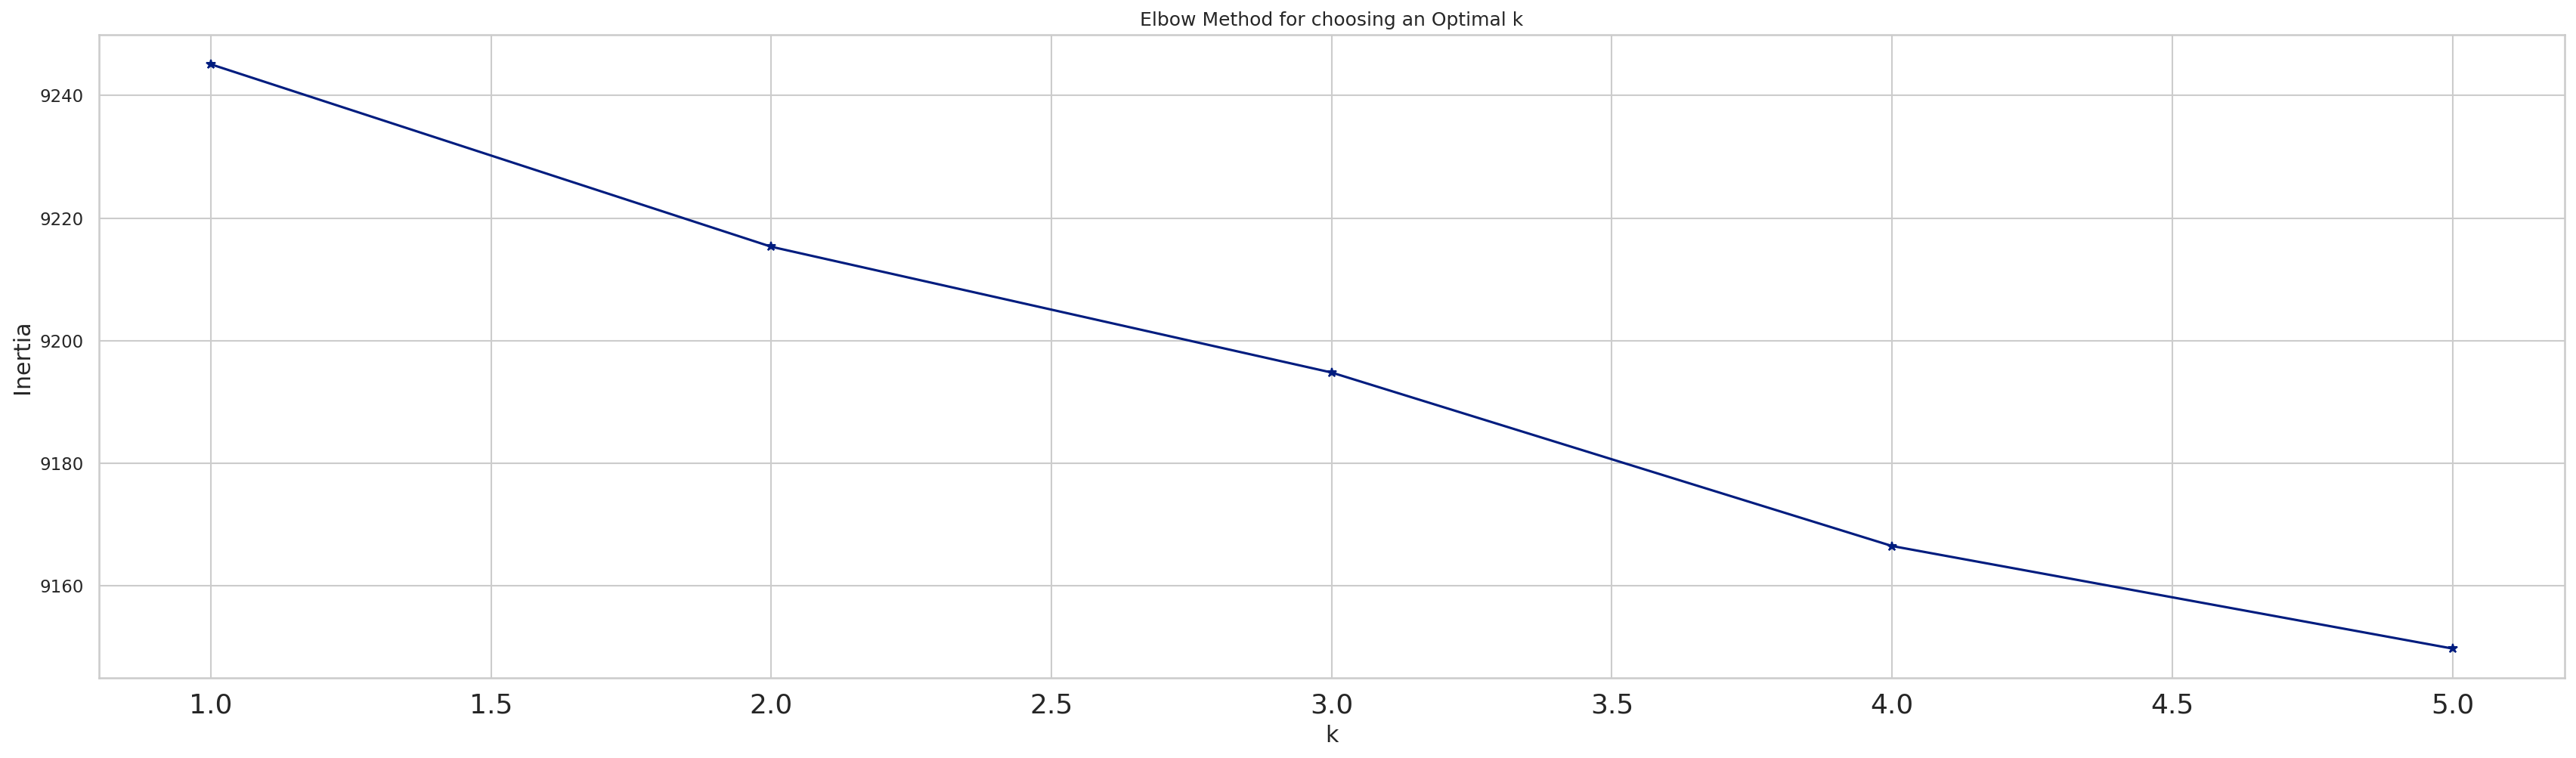

In [ ]:
# plotting the results to get the elbow point
plt.plot(range(1,6), inertia, '*-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for choosing an Optimal k')
plt.show()

**Plot Analysis**

The plot illustrates the line that helps in choosing the elbow point. It can be observed that the sum of squared errors (inertia) does not improve much after point K = 4. Hence, 4 is chosen to be the number of clusters and each document is assigned to one of the clusters using the K-Means algorithm. This value of K matches the number of topics that are there after clubbing i.e. 4.

In [ ]:
# choosing a value of k based on the elbow method
chosen_k = 4

### **Applying K-Means Algorithm**

In [ ]:
# initializing kmeans with chosen_k centroids
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', max_iter=200, n_init=10)

# fitting the model to the training data
kmeans.fit(X_train)

KMeans(max_iter=200, n_clusters=4)

In [ ]:
# storing the cluster labels
cluster_label = kmeans.labels_

In [ ]:
# viewing the cluster labels
cluster_label

array([2, 2, 0, ..., 2, 2, 3], dtype=int32)

# **Principal Component Analysis (PCA)**

In [ ]:
# viewing the shape of the training data
X_train.shape

(9650, 14798)

### **Applying PCA**

In [ ]:
# initializing PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# reducing the dimensionality
component_vectors = pca.fit_transform(X_train.toarray())

In [ ]:
# viewing the component vectors
component_vectors

array([[-0.10248158, -0.07648162],
       [-0.02988199, -0.02329773],
       [ 0.03859736, -0.03686536],
       ...,
       [-0.08154973, -0.07743482],
       [-0.05135026,  0.02550783],
       [-0.03210275,  0.36567149]])

In [ ]:
# storing the two dimensions
dimension_one = component_vectors[:, 0]
dimension_two = component_vectors[:, 1]

In [ ]:
# creating a new dataframe with details of allotted cluster and new dimensions
df_dimension_reduced_cluster = pd.DataFrame({'post' : X_train_data['post'], 'preprocessed_post' : X_train_data['preprocessed_post'], 'dimension_one' : dimension_one, 'dimension_two' : dimension_two, 'cluster_label' : cluster_label})

In [ ]:
# viewing the new dimensionaly reduced clustered dataframe
df_dimension_reduced_cluster

post  \
0     \n\nThere were many injustices in the middle a...   
1     \n\nThis actually supports Bill's speculation ...   
2     \nApplied Engineering makes a NuBus card calle...   
3     Mark McWiggins <markmc@halcyon.com> reminds us...   
4     \nExcellently put!\n\nEven as a libertarian, I...   
...                                                 ...   
9645  \nAll Toyotas have airbags with a real horn. C...   
9646    HELP!\nMaybe anybody know names of conferenc...   
9647  \nI'm not aware that the US government conside...   
9648  \n  Nut or not, he was clearly a liar.  He sai...   
9649  \nIt likely has nothing to do with "chunks of ...   

                                      preprocessed_post  dimension_one  \
0     many injustices middle ages truely sad would h...      -0.102482   
1     actually supports bill speculation backdoor rs...      -0.029882   
2     applied engineering makes nubus card called qu...       0.038597   
3     mark mcwiggins markmc halcyon com reminds us m...      -0.065279   
4     excellently put even libertarian admit governm...      -0.077332   
...                                                 ...            ...   
9645  toyotas airbags real horn come hard put little...      -0.030194   
9646  help maybe anybody know names conferences plea...       0.049998   
9647  aware us government considers dangerous case n...      -0.081550   
9648  nut clearly liar said would surrender local ra...      -0.051350   
9649  likely nothing chunks plaque sounds like may n...      -0.032103   

      dimension_two  cluster_label  
0         -0.076482              2  
1         -0.023298              2  
2         -0.036865              0  
3         -0.033008              2  
4         -0.061666              2  
...             ...            ...  
9645       0.013118              1  
9646       0.005997              1  
9647      -0.077435              2  
9648       0.025508              2  
9649       0.365671              3  

[9650 rows x 5 columns]

# **Visualization**

### **Most frequent words**

In [ ]:
number_of_terms = 23

# grouping the tf-idf vector by cluster label
df_cluster_group = pd.DataFrame(X_train.todense()).groupby(cluster_label).mean()

# accessing terms of tf-idf vector
terms = vectorizer.get_feature_names_out() 
for i,r in df_cluster_group.iterrows():
  print(f'\nCluster {i}')
  print(', '.join([terms[t] for t in np.argsort(r)[-number_of_terms:]]))


Cluster 0
pc, mb, one, hi, problem, help, system, program, get, advance, files, mail, dos, file, use, would, please, drive, know, card, anyone, thanks, windows

Cluster 1
need, see, want, used, could, may, well, much, com, time, good, new, also, think, anyone, car, edu, use, know, get, would, like, one

Cluster 2
much, also, good, law, many, see, say, time, make, well, right, even, us, could, know, key, get, like, think, government, one, would, people

Cluster 3
jxp, chastity, dsl, intellect, geb, nhl, one, pitt, good, would, teams, win, think, league, last, play, hockey, season, players, games, year, team, game


In [ ]:
# mapping clusters to the appropriate categories 
cluster_map = {0: "Computer", 1: "Science", 2: "Talk", 3: 'Recreation'}

# applying mappping to create a new column that stores the category to which the document belongs
df_dimension_reduced_cluster['cluster'] = df_dimension_reduced_cluster['cluster_label'].map(cluster_map)

In [ ]:
# viewing the newly added column i.e. cluster to see the category of each document
df_dimension_reduced_cluster

post  \
0     \n\nThere were many injustices in the middle a...   
1     \n\nThis actually supports Bill's speculation ...   
2     \nApplied Engineering makes a NuBus card calle...   
3     Mark McWiggins <markmc@halcyon.com> reminds us...   
4     \nExcellently put!\n\nEven as a libertarian, I...   
...                                                 ...   
9645  \nAll Toyotas have airbags with a real horn. C...   
9646    HELP!\nMaybe anybody know names of conferenc...   
9647  \nI'm not aware that the US government conside...   
9648  \n  Nut or not, he was clearly a liar.  He sai...   
9649  \nIt likely has nothing to do with "chunks of ...   

                                      preprocessed_post  dimension_one  \
0     many injustices middle ages truely sad would h...      -0.102482   
1     actually supports bill speculation backdoor rs...      -0.029882   
2     applied engineering makes nubus card called qu...       0.038597   
3     mark mcwiggins markmc halcyon com reminds us m...      -0.065279   
4     excellently put even libertarian admit governm...      -0.077332   
...                                                 ...            ...   
9645  toyotas airbags real horn come hard put little...      -0.030194   
9646  help maybe anybody know names conferences plea...       0.049998   
9647  aware us government considers dangerous case n...      -0.081550   
9648  nut clearly liar said would surrender local ra...      -0.051350   
9649  likely nothing chunks plaque sounds like may n...      -0.032103   

      dimension_two  cluster_label     cluster  
0         -0.076482              2        Talk  
1         -0.023298              2        Talk  
2         -0.036865              0    Computer  
3         -0.033008              2        Talk  
4         -0.061666              2        Talk  
...             ...            ...         ...  
9645       0.013118              1     Science  
9646       0.005997              1     Science  
9647      -0.077435              2        Talk  
9648       0.025508              2        Talk  
9649       0.365671              3  Recreation  

[9650 rows x 6 columns]

## **Clusters**

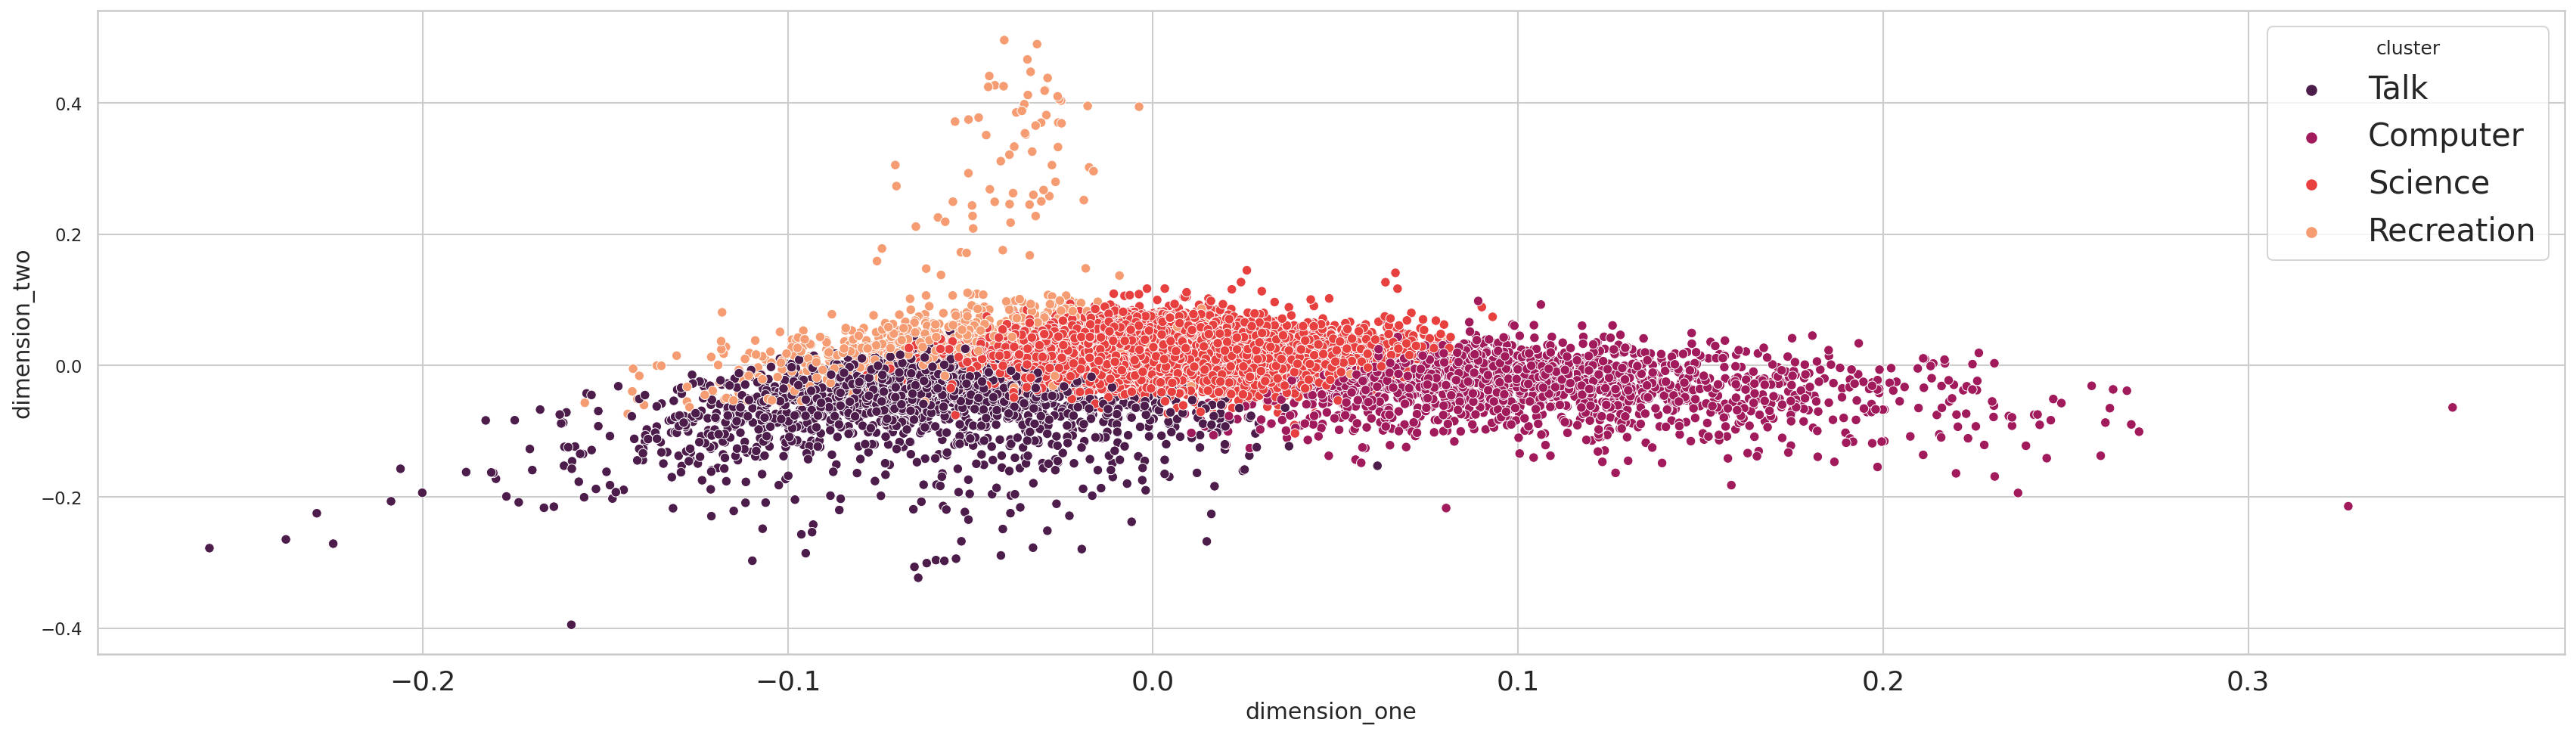

In [ ]:
# visualizing the clusters formed after kmeans and pca
sns.scatterplot(data=df_dimension_reduced_cluster, x='dimension_one', y='dimension_two', hue='cluster', palette="rocket")

**Analysis**

- Because of the reduced dimensionality, it is possible be see the 4 clusters that are formed in the 2D space. The 4 clusters correspond to the 4 clubbed groups i.e. Talk, Computer, Science, and Recreation.
- There is some overlap between the clusters of different topics. This is because there are common words that are present in the documents that belong to different topics. For instance, considering Science and Recreation clusters, words such as good, think, and one are present in the documents that belong to both the topics. Another instance is for the word think that appears in documents that belong to three of the topics i.e. Talk, Science, and Recreation.

## **Word Cloud**

Cluster Label: 0 Cluster Name: Computer


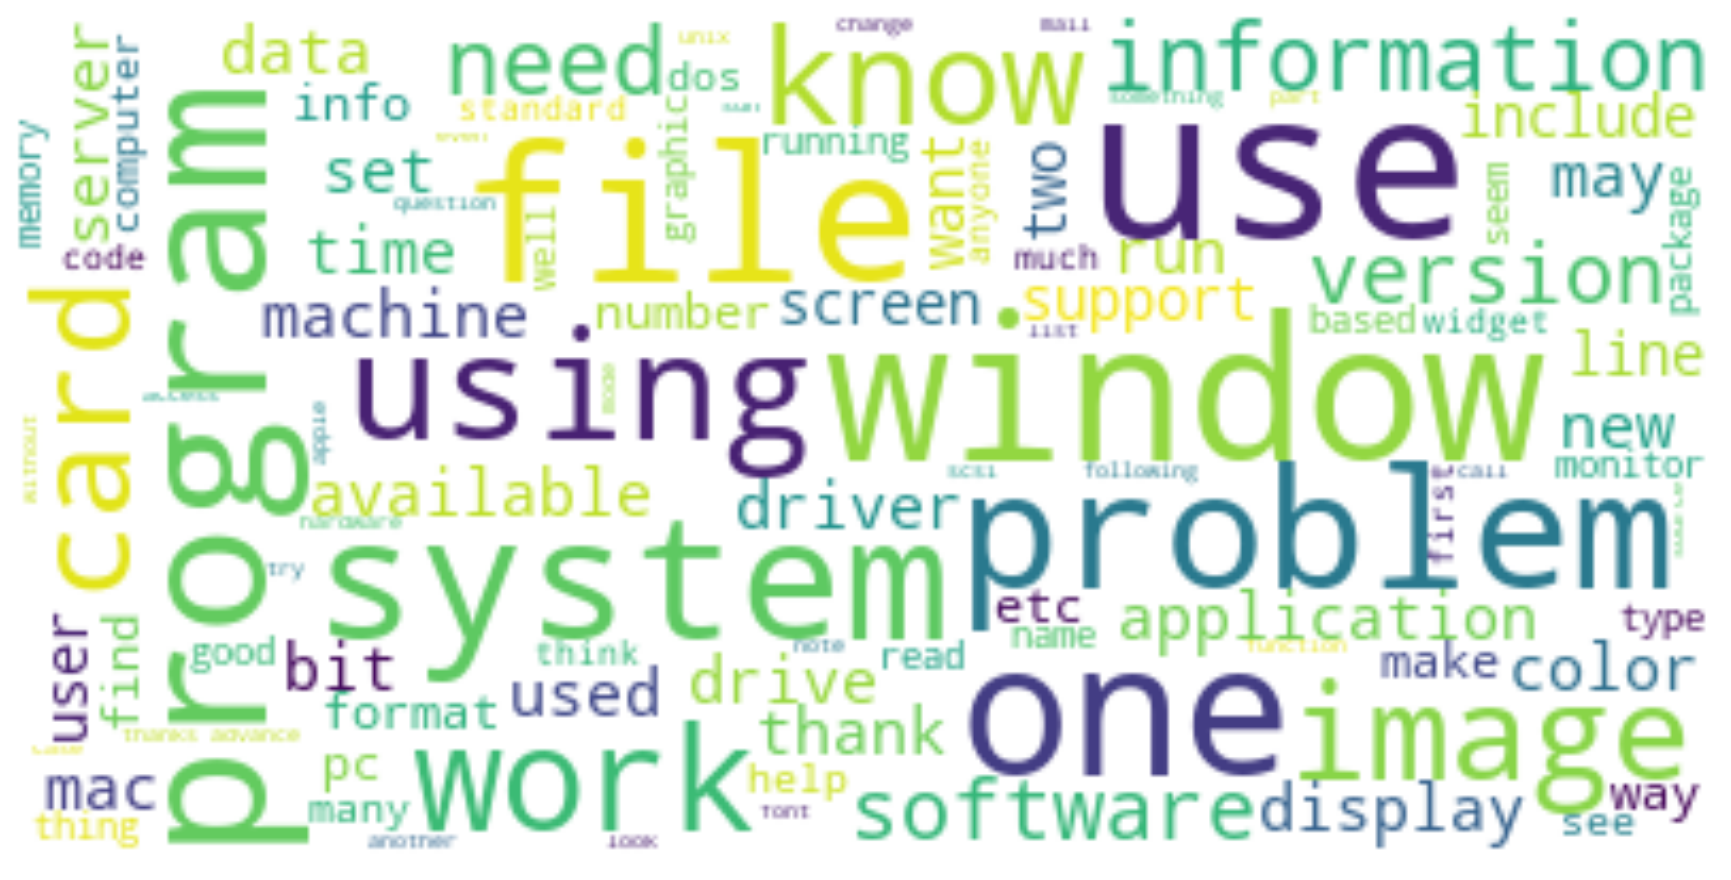

Cluster Label: 1 Cluster Name: Science


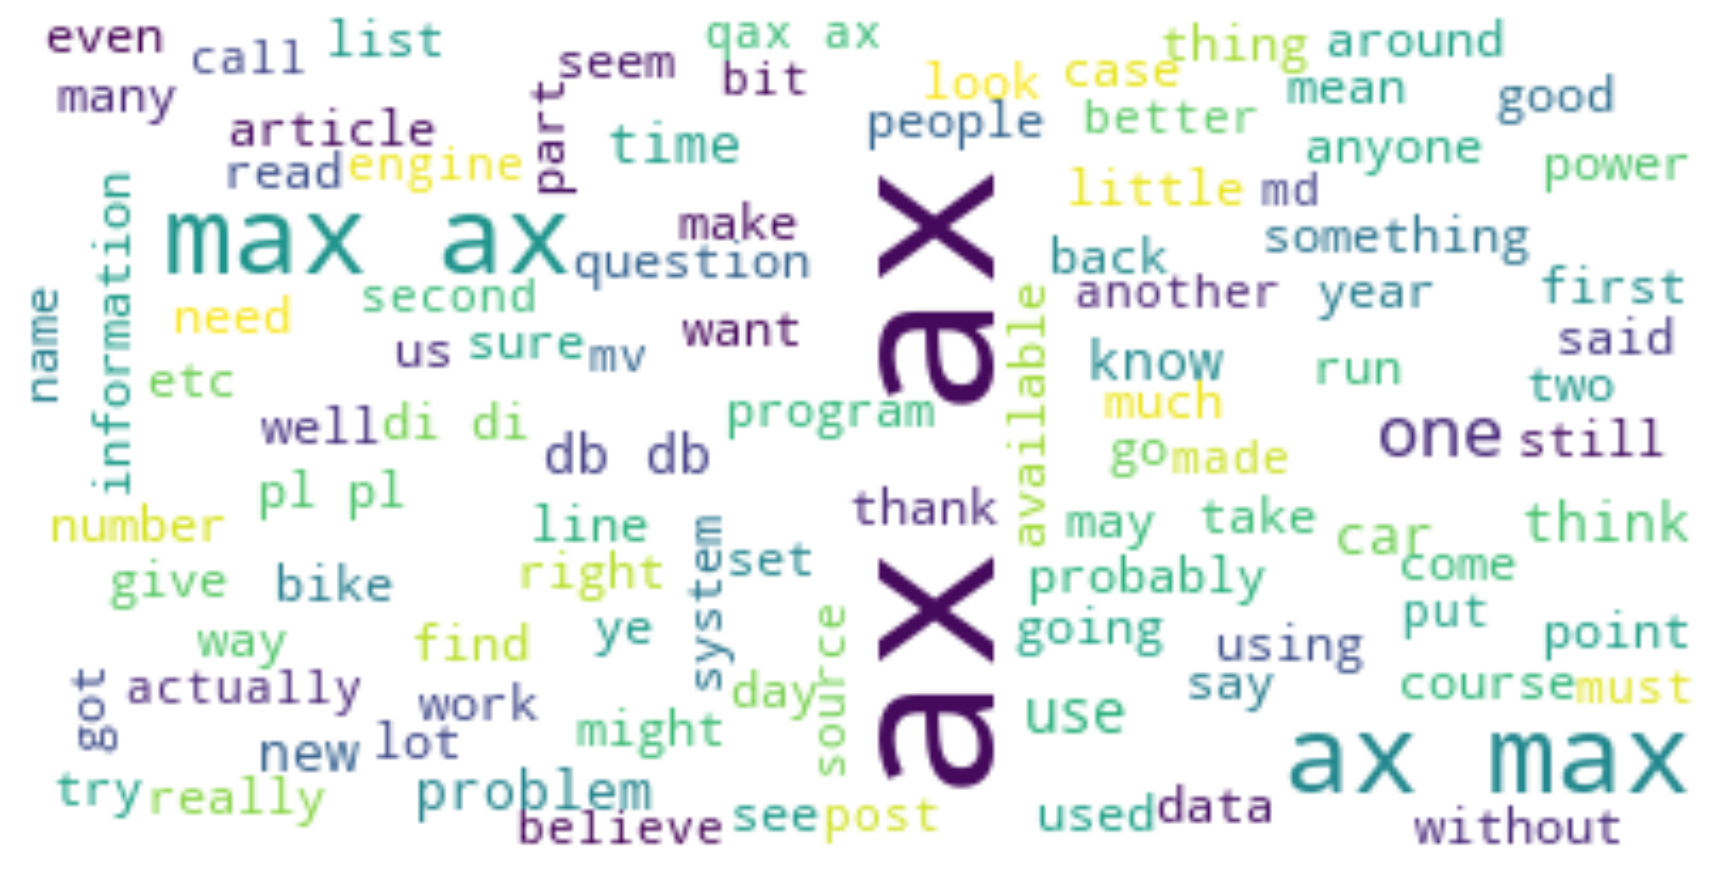

Cluster Label: 2 Cluster Name: Talk


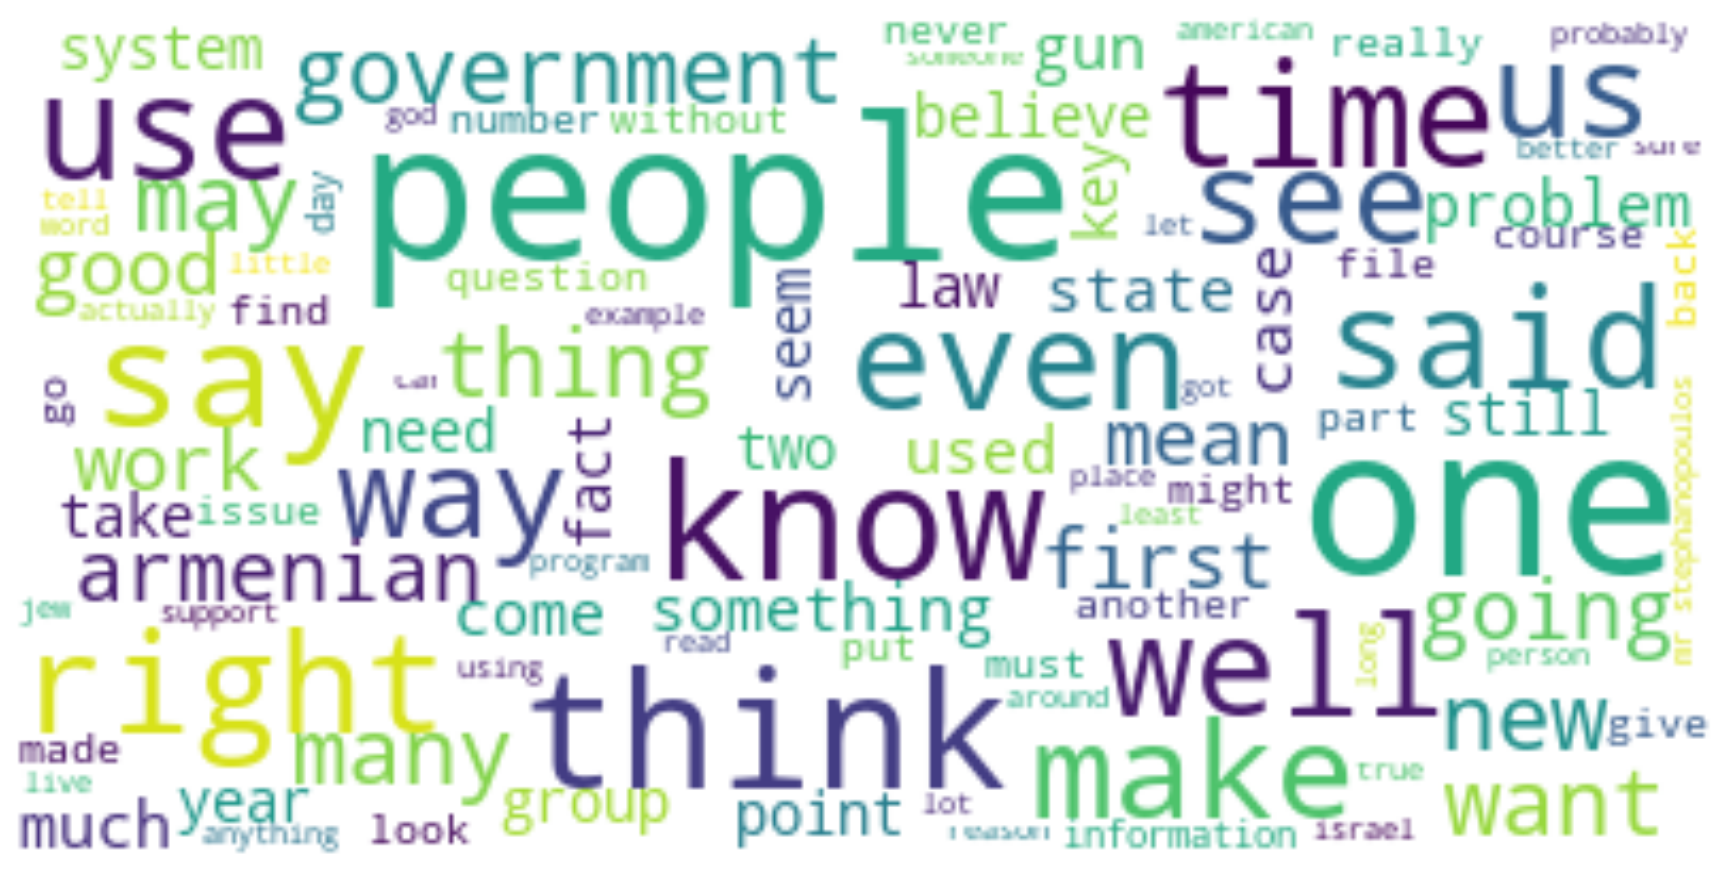

Cluster Label: 3 Cluster Name: Recreation


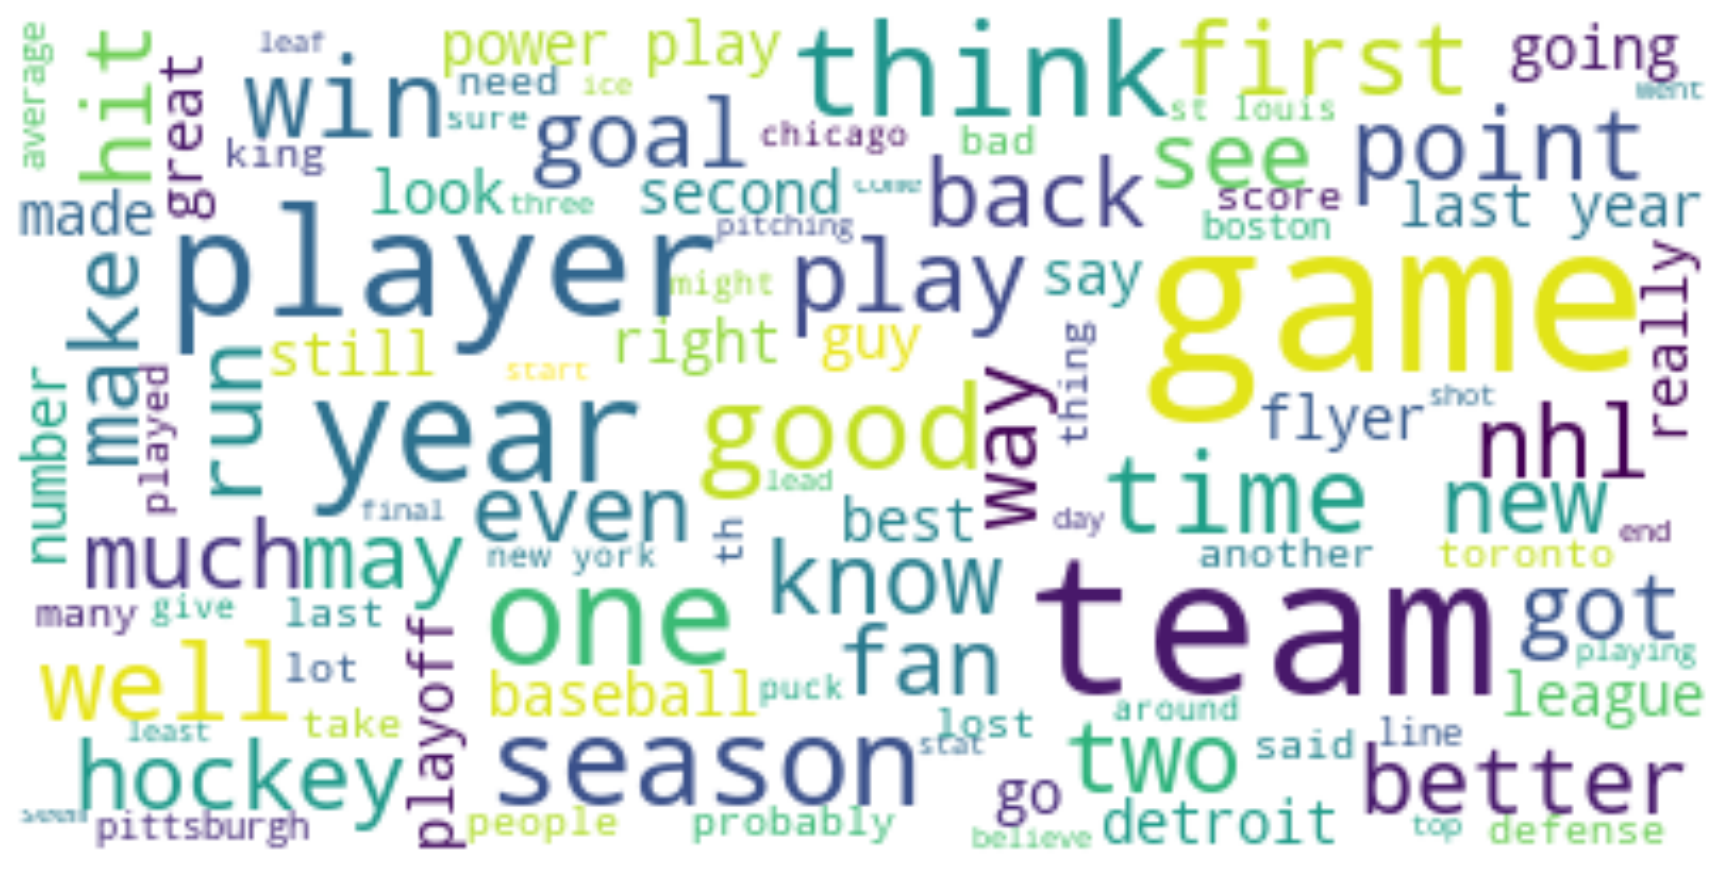

In [ ]:
# viewing the wordcloud for each of the clusters
for k in range(0,chosen_k):
   df_matched_clusters=df_dimension_reduced_cluster[df_dimension_reduced_cluster['cluster_label']==k]
   text=df_matched_clusters['preprocessed_post'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print(f'Cluster Label: {k} Cluster Name: {cluster_map[k]}')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

The word cloud is created and visualized for each of the clusters. The words which are appearing repeatedly are big in size and the occurrence or importance of the word is directly proportional to the size of the word.